# Основы машинного обучения, ИИМУП

## НИУ ВШЭ, 2024-25 учебный год

# Домашнее задание 3: Рекуррентные нейронные сети

Задание выполнил(а):

    (впишите свои фамилию и имя)

## Общая информация

__Внимание!__  


* Домашнее задание выполняется самостоятельно
* Не допускается помощь в решении домашнего задания от однокурсников или третьих лиц. «Похожие» решения считаются плагиатом, и все задействованные студенты — в том числе и те, у кого списали, — не могут получить за него больше 0 баллов
* Использование в решении домашнего задания генеративных моделей (ChatGPT и так далее) за рамками справочной и образовательной информации для генерации кода задания — считается плагиатом, и такое домашнее задание оценивается в 0 баллов
* Старайтесь сделать код как можно более оптимальным. Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит самостоятельно реализовать модель LSTM для решения задачи классификации с пересекающимися классами (multi-label classification). Это вид классификации, в которой каждый объект может относиться одновременно к нескольким классам. Такая задача часто возникает при классификации фильмов по жанрам, научных или новостных статей по темам, музыкальных композиций по инструментам и так далее.

В нашем случае мы будем работать с датасетом биотехнических новостей и классифицировать их по темам. Этот датасет уже предобработан: текст приведен к нижнему регистру, удалена пунктуация, все слова разделены проблелом.

In [ ]:
import pandas as pd

In [ ]:
BIOTECH_NEWS = 'https://www.dropbox.com/scl/fi/v624fdeg3bikyxyvr93i3/biotech_news.tsv?rlkey=iaekqfwtbqswl8vd5dpnd9d92&st=mzgbw5km&dl=1'

In [ ]:
dataset = pd.read_csv(BIOTECH_NEWS, sep='\t')
dataset.head()

,text,labels
0,drive your plow over the bones of the dead by ...,other
1,in the recently tabled national budget denel h...,other
2,shares take a break its good for you picture g...,other
3,reso is currently hiring for two positions pro...,other
4,charter buyer club what is the charter buyer c...,other


## Предобработка лейблов


__Задание 1 (1.5 балла)__. Как вы можете заметить, лейблы записаны в виде строк, разделенных запятыми. Для работы с ними нам нужно преобразовать их в числа. Так как каждый объект может принадлежать нескольким классам, закодируйте лейблы в виде векторов из 0 и 1, где 1 означает, что объект принадлежит соответствующему классу, а 0 – не принадлежит. Имея такую кодировку, мы сможем обучить модель, решая задачу бинарной классификации для каждого класса.

In [ ]:
# your code here
from sklearn.preprocessing import MultiLabelBinarizer

# Предположим, что dataset уже загружен как указано в задании
# Разделяем строку с метками на отдельные метки, используя запятую как разделитель
dataset['labels'] = dataset['labels'].str.split(', ')

# Инициализируем MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Применяем к колонке с метками
binary_labels = mlb.fit_transform(dataset['labels'])

# Теперь binary_labels - это матрица, где каждая строка соответствует объекту,
# а каждый столбец - отдельному классу. 1 означает, что объект принадлежит классу, 0 - нет.

# Если нужно добавить эти бинарные метки обратно в датасет:
labels_df = pd.DataFrame(binary_labels, columns=mlb.classes_)
dataset = pd.concat([dataset, labels_df], axis=1)

# Теперь dataset содержит бинарные колонки для каждой метки


In [ ]:
dataset


,text,labels,alliance & partnership,article publication,clinical trial sponsorship,closing,company description,department establishment,event organization,executive appointment,...,other,participation in an event,partnerships & alliances,patent publication,product launching & presentation,product updates,regulatory approval,service & product providing,subsidiary establishment,support & philanthropy
0,drive your plow over the bones of the dead by ...,[other],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,in the recently tabled national budget denel h...,[other],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,shares take a break its good for you picture g...,[other],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,reso is currently hiring for two positions pro...,[other],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,charter buyer club what is the charter buyer c...,[other],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,published less than an hour ago a grateful fam...,"[funding round, support & philanthropy, execut...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3035,a cenexelcenter of excellence joined nearly 10...,[clinical trial sponsorship],0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3036,jun 29 2020 8 47 a m pt reply in response to t...,"[new initiatives or programs, funding round, e...",0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3037,whatsapp photo supplied red river waste soluti...,"[service & product providing, closing, company...",0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Предобработка данных

В этом задании мы будем обучать рекуррентные нейронные сети. Как вы знаете, они работают лучше для коротких текстов, так как не очень хорошо улавливают далекие зависимости. Для уменьшение длин текстов их стоит почистить.

Сразу разделим выборку на обучающую и тестовую, чтобы считать все нужные статистики только по обучающей.

In [ ]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = train_test_split(
    dataset['text'],  # тексты
    binary_labels,    # обработанные бинарные метки
    test_size=0.2,  # do not change this
    random_state=0,  # do not change this

)


__Задание 2 (1.5 балла)__. Удалите из текстов стоп слова, слишком редкие и слишком частые слова. Гиперпараметры подберите самостоятельно (в идеале их стоит подбирать по качеству на тестовой выборке). Если вы считаете, что стоит добавить еще какую-то обработку, то сделайте это. Важно не удалить ничего, что может повлиять на предсказание класса.

In [ ]:
# your code here
from collections import Counter

word_counts = Counter()
doc_freq = Counter()

for text in texts_train:
    words = text.split()
    word_counts.update(words) # считаем сколько раз суммарно встретилось слово в документах
    doc_freq.update(set(words))  # считаем в скольких документах есть слово (без повторов внутри документа)

total_docs = len(texts_train)

In [ ]:
min_count = 3
max_percent = 0.7

# Слишком редкие слова (менее min_count раз)
rare_words = {word for word, cnt in word_counts.items() if cnt < min_count}

# Слишком частые слова (в более чем max_percent% документов)
common_words = {word for word, cnt in doc_freq.items() if cnt / total_docs > max_percent}

# Итоговый фильтр
words_to_remove_min_max = rare_words | common_words
print(f"Редких (< {min_count} штук): {len(rare_words)}, Частых (чаще {max_percent*100}%): {len(common_words)}")

Редких (< 3 штук): 22073, Частых (чаще 70.0%): 21


In [ ]:
common_words

{'a',
 'an',
 'and',
 'are',
 'as',
 'at',
 'by',
 'company',
 'for',
 'from',
 'has',
 'in',
 'is',
 'it',
 'of',
 'on',
 'that',
 'the',
 'this',
 'to',
 'with'}

In [ ]:
# Для чистки стоп-слов (давно уже прописаны), используем библиотеку nltk

In [ ]:
!pip install nltk
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_to_remove = stop_words.union(words_to_remove_min_max)
len(words_to_remove)

22271

In [ ]:
def filter_words(text, words_to_remove=words_to_remove):
    return ' '.join([word for word in text.split() if word not in words_to_remove])

import time
a = time.time()

cleaned_train = texts_train.apply(filter_words)
b=time.time()
print("Clean train: ", b-a)
cleaned_test = texts_test.apply(filter_words)
c=time.time()
print("Clean test: ", c-b)

Clean train:  0.5312161445617676
Clean test:  0.04268145561218262


In [ ]:
cleaned_train

,text
2925,alex waterton ceo david schwartz left pathway ...
507,workout lose weight women bodybuildig top weig...
924,burning rock biotech alerts separately zacks i...
2116,california state university largest public uni...
1363,danbury nissan infinity dealership wants take ...
...,...
763,goal create safe engaging place users connect ...
835,hattiesburg laurel airport offer flights chica...
1653,get rating announced monthly dividend tuesday ...
2607,solar mobile charger computer program used tec...


__Задание 3 (2 балла)__. Осталось перевести тексты в индексы токенов, чтобы их можно было подавать в модель. У вас есть две опции, как это сделать:
1. __(+0 баллов)__ Токенизировать тексты по словам.
2. __(до +5 баллов)__ Реализовать свою токенизацию BPE. Количество баллов будет варьироваться в зависимости от эффективности реализации. При реализации нельзя пользоваться специализированными библиотеками.

Токенизируйте тексты, переведите их в списки индексов и сложите вместе с лейблами в `DataLoader`. Не забудьте добавить в `DataLoader` `collate_fn`, которая будет дополнять все короткие тексты в батче паддингами. Для маппинга токенов в индексы вам может пригодиться `gensim.corpora.dictionary.Dictionary`.

**Реализую BPE. Использовал сайт, для понимания кода. Код переделал: https://under-sky-ai.ru/post/podrobnoe_obyyasnenie_algoritma_bpe**

In [ ]:
# Реализую класс BPE_Tokenizer, выполняющий преобразование в частотный словарь
# слов, и впоследствии объединяет наиболее часто встречающиеся по словам
# комбинации символов в токены (соединяет символы в токены, сокращая количество токенов)

# Таким образом, токены - не все буквы (тогда размер словаря будет очень велик), а  количество слияний  (merges=1000)

In [ ]:
!pip install gensim

In [ ]:
import re
from collections import defaultdict, Counter
import torch
from torch.utils.data import Dataset, DataLoader
from gensim.corpora import Dictionary
from tqdm import tqdm

class BPETokenizer:
    def __init__(self, num_merges=1000, special_tokens=None):
        self.num_merges = num_merges
        self.special_tokens = special_tokens or ['<pad>', '<unk>', '<bos>', '<eos>']
        self.vocab = None
        self.merges = None
        self.token_to_id = None
        self.id_to_token = None
        self.dictionary = None

    def _initialize_vocab(self, texts):
        vocab = Counter()
        for text in texts:
            for word in text.split():
                chars = list(word) + ['</w>']
                vocab[' '.join(chars)] += 1
        return vocab

    def _get_stats(self, vocab):
        pairs = defaultdict(int)
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pairs[(symbols[i], symbols[i+1])] += freq
        return pairs

    def _merge_vocab(self, vocab, pair):
        merged_vocab = {}
        pattern = ' '.join(pair)
        replacement = ''.join(pair)
        for word, freq in vocab.items():
            new_word = word.replace(pattern, replacement)
            merged_vocab[new_word] = freq
        return merged_vocab

    def fit(self, texts):
        vocab = self._initialize_vocab(texts)
        for token in self.special_tokens:
            vocab[token] = 1

        merges = []
        for _ in range(self.num_merges):
            pairs = self._get_stats(vocab)
            if not pairs:
                break
            best_pair = max(pairs, key=pairs.get)
            merges.append(best_pair)
            vocab = self._merge_vocab(vocab, best_pair)

        token_counts = Counter()
        for word, freq in vocab.items():
            tokens = word.split()
            token_counts.update(tokens)

        sorted_tokens = sorted(token_counts.items(), key=lambda x: (-x[1], x[0]))
        tokens = [token for token, count in sorted_tokens]

        for token in reversed(self.special_tokens):
            if token in tokens:
                tokens.remove(token)
            tokens.insert(0, token)

        # Используем gensim Dictionary для маппинга токенов
        self.dictionary = Dictionary([[t] for t in tokens])
        # Создаём словарь для специальных токенов с нужными индексами
        special_token_dict = {token: i for i, token in enumerate(self.special_tokens)}
        self.dictionary.patch_with_special_tokens(special_token_dict)
        self.token_to_id = self.dictionary.token2id
        self.id_to_token = {v: k for k, v in self.token_to_id.items()}

        self.merges = merges
        self.vocab = tokens

    def tokenize(self, text):
        if not self.token_to_id:
            raise ValueError("Tokenizer not fitted yet. Call fit() first.")

        for token in self.special_tokens:
            if token in text:
                return [token]

        tokens = list(text) + ['</w>']

        for pair in self.merges:
            new_tokens = []
            i = 0
            while i < len(tokens):
                if i < len(tokens)-1 and (tokens[i], tokens[i+1]) == pair:
                    new_tokens.append(''.join(pair))
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            tokens = new_tokens

        tokens = [token if token in self.token_to_id else '<unk>' for token in tokens]
        return tokens

    def encode(self, text):
        tokens = self.tokenize(text)
        return [self.token_to_id[token] for token in tokens]

    def decode(self, ids):
        tokens = [self.id_to_token.get(idx, '<unk>') for idx in ids]
        tokens = [token.replace('</w>', '') for token in tokens]
        return ''.join(tokens).strip()

    def get_vocab_size(self):
        return len(self.token_to_id) if self.token_to_id else 0

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=None, desc="Tokenizing"):
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encoded_texts = []
        for text in tqdm(texts, desc=desc):
            encoded = tokenizer.encode(text)
            if max_length:
                encoded = encoded[:max_length]
            self.encoded_texts.append(torch.tensor(encoded, dtype=torch.long))

        self.labels = labels

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encoded_texts[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float32)
        }




def collate_fn(batch):
    """Обрабатывает батч, добавляя паддинг к коротким последовательностям"""
    max_len = max(len(item['input_ids']) for item in batch)

    input_ids = []
    labels = []

    for item in batch:
        pad_len = max_len - len(item['input_ids'])
        padded = torch.cat([
            item['input_ids'],
            torch.zeros(pad_len, dtype=torch.long)
        ])
        input_ids.append(padded)
        labels.append(item['labels'])

    return {
        'input_ids': torch.stack(input_ids),
        'labels': torch.stack(labels)
    }



In [ ]:
# Инициализация и обучение токенизатора
import time
a = time.time()
tokenizer = BPETokenizer(num_merges=1000)  # 1000 слияний
tokenizer.fit(cleaned_train)
b=time.time()
print(f"Обучился токенизатор: {b-a}")

train_dataset = TextDataset(cleaned_train, y_train, tokenizer, max_length=128, desc="Tokenizing train")
test_dataset = TextDataset(cleaned_test, y_test, tokenizer, max_length=128, desc="Tokenizing test")

c=time.time()
print(f"Создали датасеты: {c-b}")


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

Посмотрим какие токены получились

In [ ]:
print("Все токены:", tokenizer.vocab)

## Метрика качества

Перед тем, как приступить к обучению, нам нужно выбрать метрику оценки качества. Так как в задаче классификации с пересекающимися классами классы часто несбалансированы, чаще всего в качестве метрики берется [F1 score](https://en.wikipedia.org/wiki/F-score).

Функция `compute_f1` принимает истинные метки и предсказанные и считает среднее значение F1 по всем классам. Используйте ее для оценки качества моделей.

$$
F1_{total} = \frac{1}{K} \sum_{k=1}^K F1(Y_k, \hat{Y}_k),
$$
где $Y_k$ – истинные значения для класса k, а $\hat{Y}_k$ – предсказания.

In [ ]:
from sklearn.metrics import f1_score

def compute_f1(y_true, y_pred):
    assert y_true.ndim == 2
    assert y_true.shape == y_pred.shape

    return f1_score(y_true, y_pred, average='macro')

## Обучение моделей

### RNN

В качестве бейзлайна обучим самую простую рекуррентную нейронную сеть. Напомним, что блок RNN выглядит таким образом.

<img src="https://i.postimg.cc/yYbNBm6G/tg-image-1635618906.png" alt="drawing" width="400"/>

Его скрытое состояние обновляется по формуле
$h_t = \sigma(W x_{t} + U h_{t-1} + b_h)$. А предсказание считается с помощью применения линейного слоя к последнему токену
$o_T = V h_T + b_o$. В качестве функции активации выберите гиперболический тангенс.

__Задание 4 (2 балла)__. Реализуйте RNN в соответствии с формулой выше и обучите ее на нашу задачу. Нулевой скрытый вектор инициализируйте нулями, так модель будет обучаться стабильнее, чем при случайной инициализации. После этого замеряйте качество на тестовой выборке. У вас должно получиться значение F1 не меньше 0.33, а само обучение не должно занимать много времени.

**Сама инициализация RNN**

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np

class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=1):
        super().__init__()
        # Здесь стоит поговорить для чего паддинги нужны:
        # Пусть у нас 3 предложения,
        # 1е предложение - токены [1, 2, 3]
        # 2е предложение - токены [10,20,30,40]
        # 3е предложение - токены [1, 20, 1,40, 50]
        # Тогда мы должны дозаполнить токены первого предложения: [1, 2, 3, 0, 0]; и второго: [10,20,30,40,0]
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)  # 0 для паддинга (мы не хотим учить веса, которые отвечают за паддинги - поэтому надо указать их явно 0)
        # В эмбеддинге КАЖДОМУ ТОКЕНУ в соответствие ставят вектор из 128 (в нашем случае) чисел, эти вектора "учатся"

        self.rnn = nn.RNN(embed_dim, hidden_dim, n_layers,
                         nonlinearity='tanh', batch_first=True) # тут n_layers будет 1, по заданию
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

    def forward(self, x):

        mask = (x != 0)
        lengths = mask.sum(1).cpu()
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]

        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, hn = self.rnn(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        last_seq_idxs = lengths - 1
        last_out = out[torch.arange(out.size(0)), last_seq_idxs]

        logits = self.fc(last_out)
        return logits

def train_and_evaluate(model, train_loader, test_loader, device, n_epochs=5, lr=0.001):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_f1 = 0
    f1_history = []

    for epoch in range(n_epochs):
        # Обучение
        model.train()
        train_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs}')

        for batch in progress_bar:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Оценка на тесте (происходит каждую эпоху чтобы видно было)
        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in test_loader:
                inputs = batch['input_ids'].to(device)
                labels = batch['labels'].cpu().numpy()

                outputs = model(inputs)
                preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()

                all_preds.append(preds)
                all_labels.append(labels)

        # Собираем метрики
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        f1 = compute_f1(all_labels, all_preds) # Исползуем выданную функцию

        f1_history.append(f1)

        print(f'Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Test F1: {f1:.4f}')

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_rnn_model.pt')

    print(f'Best F1: {best_f1:.4f}')
    return best_f1, f1_history

# Параметры
VOCAB_SIZE = tokenizer.get_vocab_size() + 1  # +1 для паддинга
EMBED_DIM = 128 # Размер эмбеддингов по 128
HIDDEN_DIM = 256
OUTPUT_DIM = y_train.shape[1]  # Количество классов
N_LAYERS = 1
EPOCHS = 200
LR = 0.001

# Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleRNN(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS)

# Обучение
best_f1, f1_historyRNN = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    device,
    n_epochs=EPOCHS,
    lr=LR
)

Epoch 1/200: 100%|██████████| 76/76 [00:00<00:00, 88.83it/s, loss=0.1958]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1 | Train Loss: 0.2642 | Test F1: 0.0108


Epoch 2/200: 100%|██████████| 76/76 [00:00<00:00, 98.76it/s, loss=0.1524]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 | Train Loss: 0.1809 | Test F1: 0.0231


Epoch 3/200: 100%|██████████| 76/76 [00:00<00:00, 97.83it/s, loss=0.1762]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 | Train Loss: 0.1799 | Test F1: 0.0226


Epoch 4/200: 100%|██████████| 76/76 [00:00<00:00, 98.37it/s, loss=0.1642]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 | Train Loss: 0.1781 | Test F1: 0.0070


Epoch 5/200: 100%|██████████| 76/76 [00:01<00:00, 49.86it/s, loss=0.1762]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 | Train Loss: 0.1760 | Test F1: 0.0233


Epoch 6/200: 100%|██████████| 76/76 [00:01<00:00, 48.54it/s, loss=0.1849]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6 | Train Loss: 0.1734 | Test F1: 0.0201


Epoch 7/200: 100%|██████████| 76/76 [00:00<00:00, 94.06it/s, loss=0.1799]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7 | Train Loss: 0.1707 | Test F1: 0.0180


Epoch 8/200: 100%|██████████| 76/76 [00:00<00:00, 98.20it/s, loss=0.1802]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8 | Train Loss: 0.1674 | Test F1: 0.0204


Epoch 9/200: 100%|██████████| 76/76 [00:00<00:00, 98.73it/s, loss=0.1581] 
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9 | Train Loss: 0.1635 | Test F1: 0.0279


Epoch 10/200: 100%|██████████| 76/76 [00:00<00:00, 96.55it/s, loss=0.1538]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10 | Train Loss: 0.1593 | Test F1: 0.0290


Epoch 11/200: 100%|██████████| 76/76 [00:00<00:00, 98.27it/s, loss=0.1478]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11 | Train Loss: 0.1541 | Test F1: 0.0339


Epoch 12/200: 100%|██████████| 76/76 [00:00<00:00, 96.48it/s, loss=0.1469]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12 | Train Loss: 0.1489 | Test F1: 0.0348


Epoch 13/200: 100%|██████████| 76/76 [00:00<00:00, 96.92it/s, loss=0.1480]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13 | Train Loss: 0.1437 | Test F1: 0.0353


Epoch 14/200: 100%|██████████| 76/76 [00:00<00:00, 96.42it/s, loss=0.1260]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14 | Train Loss: 0.1367 | Test F1: 0.0417


Epoch 15/200: 100%|██████████| 76/76 [00:01<00:00, 65.35it/s, loss=0.1304]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15 | Train Loss: 0.1297 | Test F1: 0.0459


Epoch 16/200: 100%|██████████| 76/76 [00:00<00:00, 83.02it/s, loss=0.1151]


Epoch 16 | Train Loss: 0.1222 | Test F1: 0.0606


Epoch 17/200: 100%|██████████| 76/76 [00:00<00:00, 76.53it/s, loss=0.1154]


Epoch 17 | Train Loss: 0.1141 | Test F1: 0.0823


Epoch 18/200: 100%|██████████| 76/76 [00:00<00:00, 76.07it/s, loss=0.0968]


Epoch 18 | Train Loss: 0.1051 | Test F1: 0.1159


Epoch 19/200: 100%|██████████| 76/76 [00:00<00:00, 89.63it/s, loss=0.0748]


Epoch 19 | Train Loss: 0.0971 | Test F1: 0.1054


Epoch 20/200: 100%|██████████| 76/76 [00:00<00:00, 97.42it/s, loss=0.0967]


Epoch 20 | Train Loss: 0.0892 | Test F1: 0.1283


Epoch 21/200: 100%|██████████| 76/76 [00:00<00:00, 98.27it/s, loss=0.0807]


Epoch 21 | Train Loss: 0.0804 | Test F1: 0.1351


Epoch 22/200: 100%|██████████| 76/76 [00:00<00:00, 98.11it/s, loss=0.0726]


Epoch 22 | Train Loss: 0.0728 | Test F1: 0.1611


Epoch 23/200: 100%|██████████| 76/76 [00:01<00:00, 63.48it/s, loss=0.0748]


Epoch 23 | Train Loss: 0.0648 | Test F1: 0.1555


Epoch 24/200: 100%|██████████| 76/76 [00:00<00:00, 81.23it/s, loss=0.0440]


Epoch 24 | Train Loss: 0.0576 | Test F1: 0.1940


Epoch 25/200: 100%|██████████| 76/76 [00:00<00:00, 96.73it/s, loss=0.0528]


Epoch 25 | Train Loss: 0.0514 | Test F1: 0.2042


Epoch 26/200: 100%|██████████| 76/76 [00:00<00:00, 97.80it/s, loss=0.0615] 


Epoch 26 | Train Loss: 0.0463 | Test F1: 0.1971


Epoch 27/200: 100%|██████████| 76/76 [00:00<00:00, 93.93it/s, loss=0.0416]


Epoch 27 | Train Loss: 0.0412 | Test F1: 0.2081


Epoch 28/200: 100%|██████████| 76/76 [00:00<00:00, 97.10it/s, loss=0.0462]


Epoch 28 | Train Loss: 0.0362 | Test F1: 0.2150


Epoch 29/200: 100%|██████████| 76/76 [00:00<00:00, 93.58it/s, loss=0.0380]


Epoch 29 | Train Loss: 0.0319 | Test F1: 0.2527


Epoch 30/200: 100%|██████████| 76/76 [00:01<00:00, 73.63it/s, loss=0.0346]


Epoch 30 | Train Loss: 0.0284 | Test F1: 0.2654


Epoch 31/200: 100%|██████████| 76/76 [00:01<00:00, 75.33it/s, loss=0.0263]


Epoch 31 | Train Loss: 0.0257 | Test F1: 0.2560


Epoch 32/200: 100%|██████████| 76/76 [00:00<00:00, 83.51it/s, loss=0.0308]


Epoch 32 | Train Loss: 0.0227 | Test F1: 0.2810


Epoch 33/200: 100%|██████████| 76/76 [00:00<00:00, 95.39it/s, loss=0.0189]


Epoch 33 | Train Loss: 0.0203 | Test F1: 0.2894


Epoch 34/200: 100%|██████████| 76/76 [00:00<00:00, 97.41it/s, loss=0.0170]


Epoch 34 | Train Loss: 0.0184 | Test F1: 0.2942


Epoch 35/200: 100%|██████████| 76/76 [00:00<00:00, 91.64it/s, loss=0.0125]


Epoch 35 | Train Loss: 0.0167 | Test F1: 0.2941


Epoch 36/200: 100%|██████████| 76/76 [00:00<00:00, 95.14it/s, loss=0.0209]


Epoch 36 | Train Loss: 0.0148 | Test F1: 0.2915


Epoch 37/200: 100%|██████████| 76/76 [00:00<00:00, 97.34it/s, loss=0.0125]


Epoch 37 | Train Loss: 0.0139 | Test F1: 0.3029


Epoch 38/200: 100%|██████████| 76/76 [00:00<00:00, 94.13it/s, loss=0.0196]


Epoch 38 | Train Loss: 0.0123 | Test F1: 0.3011


Epoch 39/200: 100%|██████████| 76/76 [00:00<00:00, 97.37it/s, loss=0.0145]


Epoch 39 | Train Loss: 0.0117 | Test F1: 0.3188


Epoch 40/200: 100%|██████████| 76/76 [00:00<00:00, 98.27it/s, loss=0.0086]


Epoch 40 | Train Loss: 0.0111 | Test F1: 0.3173


Epoch 41/200: 100%|██████████| 76/76 [00:01<00:00, 72.53it/s, loss=0.0077]


Epoch 41 | Train Loss: 0.0097 | Test F1: 0.3162


Epoch 42/200: 100%|██████████| 76/76 [00:01<00:00, 69.07it/s, loss=0.0103]


Epoch 42 | Train Loss: 0.0087 | Test F1: 0.3139


Epoch 43/200: 100%|██████████| 76/76 [00:01<00:00, 72.71it/s, loss=0.0107]


Epoch 43 | Train Loss: 0.0079 | Test F1: 0.3141


Epoch 44/200: 100%|██████████| 76/76 [00:01<00:00, 61.23it/s, loss=0.0107]


Epoch 44 | Train Loss: 0.0075 | Test F1: 0.3200


Epoch 45/200: 100%|██████████| 76/76 [00:00<00:00, 83.20it/s, loss=0.0042]


Epoch 45 | Train Loss: 0.0069 | Test F1: 0.3179


Epoch 46/200: 100%|██████████| 76/76 [00:01<00:00, 56.06it/s, loss=0.0056]


Epoch 46 | Train Loss: 0.0067 | Test F1: 0.3104


Epoch 47/200: 100%|██████████| 76/76 [00:01<00:00, 62.37it/s, loss=0.0048]


Epoch 47 | Train Loss: 0.0065 | Test F1: 0.3129


Epoch 48/200: 100%|██████████| 76/76 [00:00<00:00, 94.01it/s, loss=0.0080]


Epoch 48 | Train Loss: 0.0062 | Test F1: 0.3150


Epoch 49/200: 100%|██████████| 76/76 [00:00<00:00, 95.74it/s, loss=0.0039]


Epoch 49 | Train Loss: 0.0058 | Test F1: 0.3146


Epoch 50/200: 100%|██████████| 76/76 [00:01<00:00, 62.33it/s, loss=0.0036]


Epoch 50 | Train Loss: 0.0056 | Test F1: 0.3141


Epoch 51/200: 100%|██████████| 76/76 [00:01<00:00, 44.56it/s, loss=0.0115]


Epoch 51 | Train Loss: 0.0054 | Test F1: 0.3111


Epoch 52/200: 100%|██████████| 76/76 [00:00<00:00, 76.89it/s, loss=0.0080]


Epoch 52 | Train Loss: 0.0052 | Test F1: 0.3160


Epoch 53/200: 100%|██████████| 76/76 [00:00<00:00, 79.74it/s, loss=0.0106]


Epoch 53 | Train Loss: 0.0052 | Test F1: 0.3105


Epoch 54/200: 100%|██████████| 76/76 [00:01<00:00, 65.54it/s, loss=0.0104]


Epoch 54 | Train Loss: 0.0057 | Test F1: 0.3088


Epoch 55/200: 100%|██████████| 76/76 [00:00<00:00, 86.40it/s, loss=0.0810]


Epoch 55 | Train Loss: 0.0186 | Test F1: 0.2460


Epoch 56/200: 100%|██████████| 76/76 [00:00<00:00, 94.23it/s, loss=0.0819]


Epoch 56 | Train Loss: 0.0788 | Test F1: 0.2277


Epoch 57/200: 100%|██████████| 76/76 [00:00<00:00, 98.17it/s, loss=0.0357]


Epoch 57 | Train Loss: 0.0416 | Test F1: 0.2870


Epoch 58/200: 100%|██████████| 76/76 [00:00<00:00, 93.20it/s, loss=0.0196]


Epoch 58 | Train Loss: 0.0179 | Test F1: 0.3029


Epoch 59/200: 100%|██████████| 76/76 [00:00<00:00, 92.43it/s, loss=0.0128]


Epoch 59 | Train Loss: 0.0106 | Test F1: 0.3079


Epoch 60/200: 100%|██████████| 76/76 [00:00<00:00, 95.17it/s, loss=0.0066]


Epoch 60 | Train Loss: 0.0076 | Test F1: 0.3124


Epoch 61/200: 100%|██████████| 76/76 [00:00<00:00, 91.68it/s, loss=0.0132]


Epoch 61 | Train Loss: 0.0062 | Test F1: 0.3163


Epoch 62/200: 100%|██████████| 76/76 [00:00<00:00, 96.81it/s, loss=0.0096]


Epoch 62 | Train Loss: 0.0056 | Test F1: 0.3166


Epoch 63/200: 100%|██████████| 76/76 [00:00<00:00, 97.49it/s, loss=0.0028]


Epoch 63 | Train Loss: 0.0051 | Test F1: 0.3168


Epoch 64/200: 100%|██████████| 76/76 [00:00<00:00, 94.14it/s, loss=0.0056]


Epoch 64 | Train Loss: 0.0048 | Test F1: 0.3129


Epoch 65/200: 100%|██████████| 76/76 [00:00<00:00, 89.17it/s, loss=0.0023]


Epoch 65 | Train Loss: 0.0046 | Test F1: 0.3204


Epoch 66/200: 100%|██████████| 76/76 [00:00<00:00, 85.79it/s, loss=0.0025]


Epoch 66 | Train Loss: 0.0043 | Test F1: 0.3147


Epoch 67/200: 100%|██████████| 76/76 [00:00<00:00, 76.77it/s, loss=0.0019]


Epoch 67 | Train Loss: 0.0042 | Test F1: 0.3195


Epoch 68/200: 100%|██████████| 76/76 [00:01<00:00, 74.68it/s, loss=0.0052]


Epoch 68 | Train Loss: 0.0040 | Test F1: 0.3130


Epoch 69/200: 100%|██████████| 76/76 [00:00<00:00, 85.23it/s, loss=0.0054]


Epoch 69 | Train Loss: 0.0039 | Test F1: 0.3110


Epoch 70/200: 100%|██████████| 76/76 [00:01<00:00, 61.35it/s, loss=0.0032]


Epoch 70 | Train Loss: 0.0038 | Test F1: 0.3084


Epoch 71/200: 100%|██████████| 76/76 [00:00<00:00, 93.49it/s, loss=0.0169]


Epoch 71 | Train Loss: 0.0037 | Test F1: 0.3127


Epoch 72/200: 100%|██████████| 76/76 [00:00<00:00, 88.78it/s, loss=0.0016]


Epoch 72 | Train Loss: 0.0036 | Test F1: 0.3136


Epoch 73/200: 100%|██████████| 76/76 [00:01<00:00, 66.81it/s, loss=0.0099]


Epoch 73 | Train Loss: 0.0035 | Test F1: 0.3156


Epoch 74/200: 100%|██████████| 76/76 [00:01<00:00, 72.06it/s, loss=0.0034]


Epoch 74 | Train Loss: 0.0034 | Test F1: 0.3174


Epoch 75/200: 100%|██████████| 76/76 [00:01<00:00, 74.87it/s, loss=0.0014]


Epoch 75 | Train Loss: 0.0034 | Test F1: 0.3129


Epoch 76/200: 100%|██████████| 76/76 [00:01<00:00, 60.98it/s, loss=0.0033]


Epoch 76 | Train Loss: 0.0033 | Test F1: 0.3184


Epoch 77/200: 100%|██████████| 76/76 [00:00<00:00, 86.06it/s, loss=0.0057]


Epoch 77 | Train Loss: 0.0032 | Test F1: 0.3146


Epoch 78/200: 100%|██████████| 76/76 [00:00<00:00, 78.77it/s, loss=0.0052]


Epoch 78 | Train Loss: 0.0033 | Test F1: 0.3133


Epoch 79/200: 100%|██████████| 76/76 [00:01<00:00, 70.89it/s, loss=0.0023]


Epoch 79 | Train Loss: 0.0033 | Test F1: 0.3138


Epoch 80/200: 100%|██████████| 76/76 [00:00<00:00, 94.71it/s, loss=0.0009]


Epoch 80 | Train Loss: 0.0032 | Test F1: 0.3112


Epoch 81/200: 100%|██████████| 76/76 [00:00<00:00, 93.58it/s, loss=0.0012]


Epoch 81 | Train Loss: 0.0032 | Test F1: 0.3128


Epoch 82/200: 100%|██████████| 76/76 [00:00<00:00, 95.45it/s, loss=0.0010]


Epoch 82 | Train Loss: 0.0030 | Test F1: 0.3137


Epoch 83/200: 100%|██████████| 76/76 [00:00<00:00, 95.15it/s, loss=0.0008]


Epoch 83 | Train Loss: 0.0030 | Test F1: 0.3175


Epoch 84/200: 100%|██████████| 76/76 [00:00<00:00, 92.52it/s, loss=0.0069]


Epoch 84 | Train Loss: 0.0030 | Test F1: 0.3153


Epoch 85/200: 100%|██████████| 76/76 [00:00<00:00, 90.18it/s, loss=0.0043]


Epoch 85 | Train Loss: 0.0030 | Test F1: 0.3222


Epoch 86/200: 100%|██████████| 76/76 [00:00<00:00, 93.19it/s, loss=0.0019]


Epoch 86 | Train Loss: 0.0030 | Test F1: 0.3157


Epoch 87/200: 100%|██████████| 76/76 [00:00<00:00, 91.61it/s, loss=0.0006]


Epoch 87 | Train Loss: 0.0029 | Test F1: 0.3177


Epoch 88/200: 100%|██████████| 76/76 [00:00<00:00, 92.47it/s, loss=0.0045]


Epoch 88 | Train Loss: 0.0030 | Test F1: 0.3194


Epoch 89/200: 100%|██████████| 76/76 [00:00<00:00, 94.68it/s, loss=0.0053]


Epoch 89 | Train Loss: 0.0030 | Test F1: 0.3254


Epoch 90/200: 100%|██████████| 76/76 [00:00<00:00, 95.28it/s, loss=0.0026]


Epoch 90 | Train Loss: 0.0029 | Test F1: 0.3155


Epoch 91/200: 100%|██████████| 76/76 [00:01<00:00, 62.45it/s, loss=0.0008]


Epoch 91 | Train Loss: 0.0029 | Test F1: 0.3201


Epoch 92/200: 100%|██████████| 76/76 [00:01<00:00, 75.83it/s, loss=0.0006]


Epoch 92 | Train Loss: 0.0030 | Test F1: 0.3238


Epoch 93/200: 100%|██████████| 76/76 [00:00<00:00, 81.03it/s, loss=0.0055]


Epoch 93 | Train Loss: 0.0029 | Test F1: 0.3213


Epoch 94/200: 100%|██████████| 76/76 [00:00<00:00, 90.89it/s, loss=0.0007]


Epoch 94 | Train Loss: 0.0028 | Test F1: 0.3203


Epoch 95/200: 100%|██████████| 76/76 [00:00<00:00, 91.76it/s, loss=0.0028]


Epoch 95 | Train Loss: 0.0030 | Test F1: 0.3213


Epoch 96/200: 100%|██████████| 76/76 [00:00<00:00, 92.72it/s, loss=0.0083]


Epoch 96 | Train Loss: 0.0041 | Test F1: 0.3195


Epoch 97/200: 100%|██████████| 76/76 [00:00<00:00, 93.63it/s, loss=0.1027]


Epoch 97 | Train Loss: 0.0960 | Test F1: 0.2047


Epoch 98/200: 100%|██████████| 76/76 [00:00<00:00, 94.66it/s, loss=0.0615]


Epoch 98 | Train Loss: 0.0580 | Test F1: 0.2381


Epoch 99/200: 100%|██████████| 76/76 [00:00<00:00, 94.57it/s, loss=0.0269]


Epoch 99 | Train Loss: 0.0259 | Test F1: 0.2994


Epoch 100/200: 100%|██████████| 76/76 [00:00<00:00, 94.91it/s, loss=0.0095]


Epoch 100 | Train Loss: 0.0134 | Test F1: 0.3199


Epoch 101/200: 100%|██████████| 76/76 [00:00<00:00, 95.37it/s, loss=0.0112]


Epoch 101 | Train Loss: 0.0080 | Test F1: 0.3100


Epoch 102/200: 100%|██████████| 76/76 [00:00<00:00, 95.62it/s, loss=0.0078]


Epoch 102 | Train Loss: 0.0061 | Test F1: 0.3166


Epoch 103/200: 100%|██████████| 76/76 [00:00<00:00, 95.71it/s, loss=0.0028]


Epoch 103 | Train Loss: 0.0051 | Test F1: 0.3165


Epoch 104/200: 100%|██████████| 76/76 [00:00<00:00, 87.16it/s, loss=0.0059]


Epoch 104 | Train Loss: 0.0045 | Test F1: 0.3194


Epoch 105/200: 100%|██████████| 76/76 [00:01<00:00, 75.25it/s, loss=0.0022]


Epoch 105 | Train Loss: 0.0042 | Test F1: 0.3119


Epoch 106/200: 100%|██████████| 76/76 [00:01<00:00, 72.73it/s, loss=0.0033]


Epoch 106 | Train Loss: 0.0040 | Test F1: 0.3142


Epoch 107/200: 100%|██████████| 76/76 [00:00<00:00, 86.99it/s, loss=0.0055]


Epoch 107 | Train Loss: 0.0038 | Test F1: 0.3123


Epoch 108/200: 100%|██████████| 76/76 [00:00<00:00, 95.54it/s, loss=0.0019]


Epoch 108 | Train Loss: 0.0037 | Test F1: 0.3164


Epoch 109/200: 100%|██████████| 76/76 [00:00<00:00, 94.50it/s, loss=0.0016]


Epoch 109 | Train Loss: 0.0035 | Test F1: 0.3140


Epoch 110/200: 100%|██████████| 76/76 [00:00<00:00, 95.50it/s, loss=0.0087]


Epoch 110 | Train Loss: 0.0035 | Test F1: 0.3172


Epoch 111/200: 100%|██████████| 76/76 [00:00<00:00, 93.09it/s, loss=0.0060]


Epoch 111 | Train Loss: 0.0034 | Test F1: 0.3139


Epoch 112/200: 100%|██████████| 76/76 [00:00<00:00, 93.21it/s, loss=0.0055]


Epoch 112 | Train Loss: 0.0032 | Test F1: 0.3164


Epoch 113/200: 100%|██████████| 76/76 [00:00<00:00, 91.20it/s, loss=0.0008]


Epoch 113 | Train Loss: 0.0032 | Test F1: 0.3126


Epoch 114/200: 100%|██████████| 76/76 [00:00<00:00, 91.85it/s, loss=0.0043]


Epoch 114 | Train Loss: 0.0031 | Test F1: 0.3177


Epoch 115/200: 100%|██████████| 76/76 [00:00<00:00, 91.28it/s, loss=0.0061]


Epoch 115 | Train Loss: 0.0031 | Test F1: 0.3178


Epoch 116/200: 100%|██████████| 76/76 [00:00<00:00, 91.15it/s, loss=0.0027]


Epoch 116 | Train Loss: 0.0030 | Test F1: 0.3164


Epoch 117/200: 100%|██████████| 76/76 [00:00<00:00, 93.88it/s, loss=0.0016]


Epoch 117 | Train Loss: 0.0031 | Test F1: 0.3198


Epoch 118/200: 100%|██████████| 76/76 [00:01<00:00, 73.86it/s, loss=0.0024]


Epoch 118 | Train Loss: 0.0029 | Test F1: 0.3168


Epoch 119/200: 100%|██████████| 76/76 [00:01<00:00, 70.62it/s, loss=0.0008]


Epoch 119 | Train Loss: 0.0030 | Test F1: 0.3163


Epoch 120/200: 100%|██████████| 76/76 [00:00<00:00, 87.04it/s, loss=0.0069]


Epoch 120 | Train Loss: 0.0029 | Test F1: 0.3180


Epoch 121/200: 100%|██████████| 76/76 [00:00<00:00, 91.99it/s, loss=0.0006]


Epoch 121 | Train Loss: 0.0029 | Test F1: 0.3192


Epoch 122/200: 100%|██████████| 76/76 [00:00<00:00, 94.31it/s, loss=0.0065]


Epoch 122 | Train Loss: 0.0028 | Test F1: 0.3163


Epoch 123/200: 100%|██████████| 76/76 [00:00<00:00, 93.88it/s, loss=0.0011]


Epoch 123 | Train Loss: 0.0028 | Test F1: 0.3152


Epoch 124/200: 100%|██████████| 76/76 [00:00<00:00, 92.41it/s, loss=0.0021]


Epoch 124 | Train Loss: 0.0029 | Test F1: 0.3194


Epoch 125/200: 100%|██████████| 76/76 [00:00<00:00, 92.15it/s, loss=0.0018]


Epoch 125 | Train Loss: 0.0028 | Test F1: 0.3179


Epoch 126/200: 100%|██████████| 76/76 [00:00<00:00, 91.88it/s, loss=0.0032]


Epoch 126 | Train Loss: 0.0027 | Test F1: 0.3166


Epoch 127/200: 100%|██████████| 76/76 [00:00<00:00, 91.31it/s, loss=0.0062]


Epoch 127 | Train Loss: 0.0027 | Test F1: 0.3169


Epoch 128/200: 100%|██████████| 76/76 [00:00<00:00, 94.21it/s, loss=0.0024]


Epoch 128 | Train Loss: 0.0027 | Test F1: 0.3180


Epoch 129/200: 100%|██████████| 76/76 [00:00<00:00, 92.92it/s, loss=0.0075]


Epoch 129 | Train Loss: 0.0027 | Test F1: 0.3172


Epoch 130/200: 100%|██████████| 76/76 [00:00<00:00, 93.08it/s, loss=0.0030]


Epoch 130 | Train Loss: 0.0026 | Test F1: 0.3178


Epoch 131/200: 100%|██████████| 76/76 [00:00<00:00, 83.08it/s, loss=0.0062]


Epoch 131 | Train Loss: 0.0026 | Test F1: 0.3181


Epoch 132/200: 100%|██████████| 76/76 [00:00<00:00, 79.83it/s, loss=0.0005]


Epoch 132 | Train Loss: 0.0026 | Test F1: 0.3179


Epoch 133/200: 100%|██████████| 76/76 [00:01<00:00, 71.18it/s, loss=0.0015]


Epoch 133 | Train Loss: 0.0026 | Test F1: 0.3207


Epoch 134/200: 100%|██████████| 76/76 [00:00<00:00, 94.63it/s, loss=0.0019]


Epoch 134 | Train Loss: 0.0026 | Test F1: 0.3216


Epoch 135/200: 100%|██████████| 76/76 [00:01<00:00, 68.16it/s, loss=0.0003]


Epoch 135 | Train Loss: 0.0026 | Test F1: 0.3205


Epoch 136/200: 100%|██████████| 76/76 [00:01<00:00, 66.93it/s, loss=0.0056]


Epoch 136 | Train Loss: 0.0026 | Test F1: 0.3211


Epoch 137/200: 100%|██████████| 76/76 [00:00<00:00, 94.26it/s, loss=0.0017]


Epoch 137 | Train Loss: 0.0026 | Test F1: 0.3215


Epoch 138/200: 100%|██████████| 76/76 [00:00<00:00, 94.90it/s, loss=0.0054]


Epoch 138 | Train Loss: 0.0026 | Test F1: 0.3179


Epoch 139/200: 100%|██████████| 76/76 [00:00<00:00, 92.28it/s, loss=0.0003]


Epoch 139 | Train Loss: 0.0026 | Test F1: 0.3163


Epoch 140/200: 100%|██████████| 76/76 [00:00<00:00, 92.36it/s, loss=0.0026]


Epoch 140 | Train Loss: 0.0026 | Test F1: 0.3190


Epoch 141/200: 100%|██████████| 76/76 [00:00<00:00, 93.66it/s, loss=0.0010]


Epoch 141 | Train Loss: 0.0026 | Test F1: 0.3215


Epoch 142/200: 100%|██████████| 76/76 [00:00<00:00, 93.19it/s, loss=0.0004]


Epoch 142 | Train Loss: 0.0026 | Test F1: 0.3204


Epoch 143/200: 100%|██████████| 76/76 [00:00<00:00, 93.19it/s, loss=0.0021]


Epoch 143 | Train Loss: 0.0025 | Test F1: 0.3204


Epoch 144/200: 100%|██████████| 76/76 [00:00<00:00, 79.30it/s, loss=0.1643]


Epoch 144 | Train Loss: 0.0352 | Test F1: 0.2002


Epoch 145/200: 100%|██████████| 76/76 [00:00<00:00, 77.46it/s, loss=0.0852]


Epoch 145 | Train Loss: 0.1072 | Test F1: 0.2018


Epoch 146/200: 100%|██████████| 76/76 [00:01<00:00, 74.23it/s, loss=0.0489]


Epoch 146 | Train Loss: 0.0533 | Test F1: 0.2491


Epoch 147/200: 100%|██████████| 76/76 [00:00<00:00, 90.45it/s, loss=0.0234]


Epoch 147 | Train Loss: 0.0271 | Test F1: 0.2683


Epoch 148/200: 100%|██████████| 76/76 [00:00<00:00, 91.32it/s, loss=0.0236]


Epoch 148 | Train Loss: 0.0149 | Test F1: 0.3059


Epoch 149/200: 100%|██████████| 76/76 [00:00<00:00, 77.13it/s, loss=0.0057]


Epoch 149 | Train Loss: 0.0091 | Test F1: 0.3026


Epoch 150/200: 100%|██████████| 76/76 [00:00<00:00, 92.97it/s, loss=0.0045]


Epoch 150 | Train Loss: 0.0064 | Test F1: 0.3072


Epoch 151/200: 100%|██████████| 76/76 [00:00<00:00, 92.97it/s, loss=0.0034]


Epoch 151 | Train Loss: 0.0052 | Test F1: 0.3081


Epoch 152/200: 100%|██████████| 76/76 [00:00<00:00, 94.03it/s, loss=0.0101]


Epoch 152 | Train Loss: 0.0047 | Test F1: 0.3057


Epoch 153/200: 100%|██████████| 76/76 [00:00<00:00, 90.97it/s, loss=0.0098]


Epoch 153 | Train Loss: 0.0043 | Test F1: 0.3080


Epoch 154/200: 100%|██████████| 76/76 [00:00<00:00, 91.61it/s, loss=0.0021]


Epoch 154 | Train Loss: 0.0041 | Test F1: 0.3078


Epoch 155/200: 100%|██████████| 76/76 [00:00<00:00, 90.24it/s, loss=0.0044]


Epoch 155 | Train Loss: 0.0038 | Test F1: 0.3083


Epoch 156/200: 100%|██████████| 76/76 [00:00<00:00, 93.33it/s, loss=0.0015]


Epoch 156 | Train Loss: 0.0037 | Test F1: 0.3088


Epoch 157/200: 100%|██████████| 76/76 [00:00<00:00, 79.60it/s, loss=0.0051]


Epoch 157 | Train Loss: 0.0036 | Test F1: 0.3060


Epoch 158/200: 100%|██████████| 76/76 [00:00<00:00, 78.53it/s, loss=0.0055]


Epoch 158 | Train Loss: 0.0034 | Test F1: 0.3073


Epoch 159/200: 100%|██████████| 76/76 [00:01<00:00, 72.91it/s, loss=0.0030]


Epoch 159 | Train Loss: 0.0033 | Test F1: 0.3098


Epoch 160/200: 100%|██████████| 76/76 [00:00<00:00, 94.94it/s, loss=0.0101]


Epoch 160 | Train Loss: 0.0032 | Test F1: 0.3082


Epoch 161/200: 100%|██████████| 76/76 [00:00<00:00, 91.16it/s, loss=0.0041]


Epoch 161 | Train Loss: 0.0032 | Test F1: 0.3063


Epoch 162/200: 100%|██████████| 76/76 [00:00<00:00, 93.91it/s, loss=0.0021]


Epoch 162 | Train Loss: 0.0031 | Test F1: 0.3123


Epoch 163/200: 100%|██████████| 76/76 [00:00<00:00, 92.72it/s, loss=0.0086]


Epoch 163 | Train Loss: 0.0031 | Test F1: 0.3119


Epoch 164/200: 100%|██████████| 76/76 [00:00<00:00, 92.05it/s, loss=0.0029]


Epoch 164 | Train Loss: 0.0030 | Test F1: 0.3090


Epoch 165/200: 100%|██████████| 76/76 [00:00<00:00, 92.22it/s, loss=0.0022]


Epoch 165 | Train Loss: 0.0030 | Test F1: 0.3069


Epoch 166/200: 100%|██████████| 76/76 [00:00<00:00, 93.09it/s, loss=0.0010]


Epoch 166 | Train Loss: 0.0030 | Test F1: 0.3106


Epoch 167/200: 100%|██████████| 76/76 [00:00<00:00, 91.63it/s, loss=0.0039]


Epoch 167 | Train Loss: 0.0029 | Test F1: 0.3108


Epoch 168/200: 100%|██████████| 76/76 [00:00<00:00, 91.79it/s, loss=0.0013]


Epoch 168 | Train Loss: 0.0029 | Test F1: 0.3137


Epoch 169/200: 100%|██████████| 76/76 [00:00<00:00, 89.42it/s, loss=0.0028]


Epoch 169 | Train Loss: 0.0029 | Test F1: 0.3123


Epoch 170/200: 100%|██████████| 76/76 [00:00<00:00, 94.47it/s, loss=0.0059]


Epoch 170 | Train Loss: 0.0029 | Test F1: 0.3083


Epoch 171/200: 100%|██████████| 76/76 [00:01<00:00, 74.18it/s, loss=0.0050]


Epoch 171 | Train Loss: 0.0028 | Test F1: 0.3103


Epoch 172/200: 100%|██████████| 76/76 [00:01<00:00, 74.99it/s, loss=0.0042]


Epoch 172 | Train Loss: 0.0028 | Test F1: 0.3123


Epoch 173/200: 100%|██████████| 76/76 [00:00<00:00, 77.51it/s, loss=0.0046]


Epoch 173 | Train Loss: 0.0028 | Test F1: 0.3105


Epoch 174/200: 100%|██████████| 76/76 [00:00<00:00, 93.39it/s, loss=0.0061]


Epoch 174 | Train Loss: 0.0028 | Test F1: 0.3117


Epoch 175/200: 100%|██████████| 76/76 [00:00<00:00, 91.76it/s, loss=0.0025]


Epoch 175 | Train Loss: 0.0027 | Test F1: 0.3145


Epoch 176/200: 100%|██████████| 76/76 [00:00<00:00, 92.52it/s, loss=0.0019]


Epoch 176 | Train Loss: 0.0027 | Test F1: 0.3158


Epoch 177/200: 100%|██████████| 76/76 [00:00<00:00, 93.49it/s, loss=0.0052]


Epoch 177 | Train Loss: 0.0027 | Test F1: 0.3137


Epoch 178/200: 100%|██████████| 76/76 [00:00<00:00, 94.47it/s, loss=0.0025]


Epoch 178 | Train Loss: 0.0027 | Test F1: 0.3115


Epoch 179/200: 100%|██████████| 76/76 [00:00<00:00, 93.76it/s, loss=0.0020]


Epoch 179 | Train Loss: 0.0027 | Test F1: 0.3126


Epoch 180/200: 100%|██████████| 76/76 [00:00<00:00, 93.64it/s, loss=0.0053]


Epoch 180 | Train Loss: 0.0026 | Test F1: 0.3138


Epoch 181/200: 100%|██████████| 76/76 [00:00<00:00, 91.53it/s, loss=0.0033]


Epoch 181 | Train Loss: 0.0026 | Test F1: 0.3130


Epoch 182/200: 100%|██████████| 76/76 [00:00<00:00, 90.21it/s, loss=0.0005]


Epoch 182 | Train Loss: 0.0026 | Test F1: 0.3109


Epoch 183/200: 100%|██████████| 76/76 [00:00<00:00, 90.33it/s, loss=0.0090]


Epoch 183 | Train Loss: 0.0026 | Test F1: 0.3119


Epoch 184/200: 100%|██████████| 76/76 [00:00<00:00, 85.99it/s, loss=0.0052]


Epoch 184 | Train Loss: 0.0026 | Test F1: 0.3133


Epoch 185/200: 100%|██████████| 76/76 [00:01<00:00, 70.93it/s, loss=0.0072]


Epoch 185 | Train Loss: 0.0026 | Test F1: 0.3162


Epoch 186/200: 100%|██████████| 76/76 [00:01<00:00, 68.57it/s, loss=0.0004]


Epoch 186 | Train Loss: 0.0025 | Test F1: 0.3116


Epoch 187/200: 100%|██████████| 76/76 [00:00<00:00, 91.92it/s, loss=0.0022]


Epoch 187 | Train Loss: 0.0025 | Test F1: 0.3175


Epoch 188/200: 100%|██████████| 76/76 [00:00<00:00, 91.72it/s, loss=0.0064]


Epoch 188 | Train Loss: 0.0025 | Test F1: 0.3119


Epoch 189/200: 100%|██████████| 76/76 [00:00<00:00, 90.69it/s, loss=0.0016]


Epoch 189 | Train Loss: 0.0025 | Test F1: 0.3113


Epoch 190/200: 100%|██████████| 76/76 [00:00<00:00, 89.69it/s, loss=0.0002]


Epoch 190 | Train Loss: 0.0024 | Test F1: 0.3135


Epoch 191/200: 100%|██████████| 76/76 [00:00<00:00, 90.27it/s, loss=0.0043]


Epoch 191 | Train Loss: 0.0025 | Test F1: 0.3126


Epoch 192/200: 100%|██████████| 76/76 [00:00<00:00, 85.10it/s, loss=0.0033]


Epoch 192 | Train Loss: 0.0025 | Test F1: 0.3136


Epoch 193/200: 100%|██████████| 76/76 [00:00<00:00, 91.76it/s, loss=0.0037]


Epoch 193 | Train Loss: 0.0025 | Test F1: 0.3171


Epoch 194/200: 100%|██████████| 76/76 [00:00<00:00, 93.72it/s, loss=0.0103]


Epoch 194 | Train Loss: 0.0025 | Test F1: 0.3167


Epoch 195/200: 100%|██████████| 76/76 [00:00<00:00, 93.70it/s, loss=0.0477]


Epoch 195 | Train Loss: 0.0072 | Test F1: 0.2373


Epoch 196/200: 100%|██████████| 76/76 [00:00<00:00, 87.90it/s, loss=0.1429]


Epoch 196 | Train Loss: 0.1148 | Test F1: 0.1713


Epoch 197/200: 100%|██████████| 76/76 [00:00<00:00, 92.03it/s, loss=0.0587]


Epoch 197 | Train Loss: 0.0695 | Test F1: 0.2330


Epoch 198/200: 100%|██████████| 76/76 [00:01<00:00, 73.66it/s, loss=0.0248]


Epoch 198 | Train Loss: 0.0345 | Test F1: 0.2641


Epoch 199/200: 100%|██████████| 76/76 [00:00<00:00, 76.82it/s, loss=0.0162]


Epoch 199 | Train Loss: 0.0196 | Test F1: 0.3067


Epoch 200/200: 100%|██████████| 76/76 [00:00<00:00, 76.63it/s, loss=0.0110]


Epoch 200 | Train Loss: 0.0118 | Test F1: 0.3006
Best F1: 0.3254


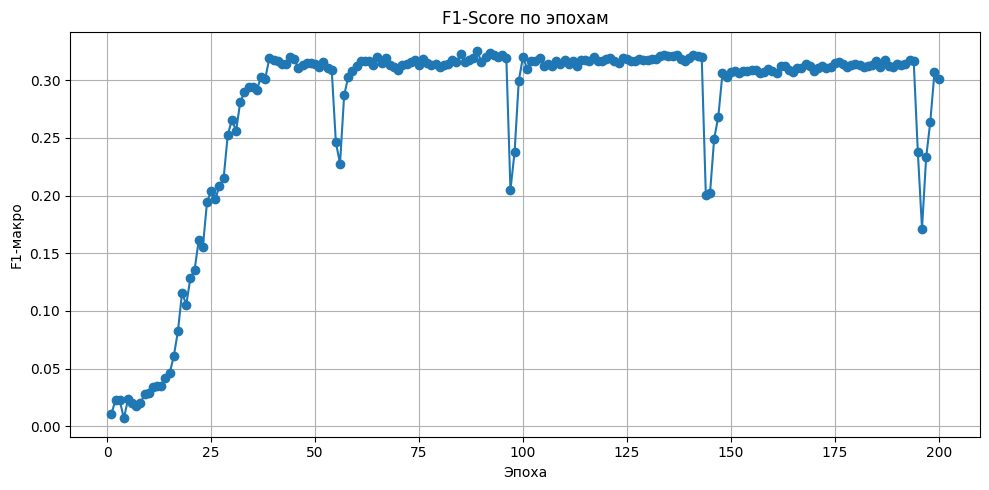

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), f1_historyRNN, marker='o')
plt.title("F1-Score по эпохам RNN")
plt.xlabel("Эпоха")
plt.ylabel("F1-макро")
plt.grid(True)
plt.tight_layout()
plt.show()

### LSTM

<img src="https://i.postimg.cc/pL5LdmpL/tg-image-2290675322.png" alt="drawing" width="400"/>

Теперь перейдем к более продвинутым рекурренным моделям, а именно LSTM. Из-за дополнительного вектора памяти эта модель должна гораздо лучше улавливать далекие зависимости, что должно напрямую отражаться на качестве.

Параметры блока LSTM обновляются вот так ($\sigma$ означает сигмоиду):
\begin{align}
f_{t} &= \sigma(W_f x_{t} + U_f h_{t-1} + b_f) \\
i_{t} &= \sigma(W_i x_{t} + U_i h_{t-1} + b_i) \\
\tilde{c}_{t} &= \tanh(W_c x_{t} + U_c h_{t-1} + b_i) \\
c_{t} &= f_t \odot c_{t-1} + i_t \odot \tilde{c}_t \\
o_{t} &= \sigma(W_t x_{t} + U_t h_{t-1} + b_t) \\
h_t &= o_t \odot \tanh(c_t)
\end{align}

__Задание 5 (2 балла).__ Реализуйте LSTM по описанной схеме. Выберите гиперпараметры LSTM так, чтобы их общее число (без учета слоя эмбеддингов) примерно совпадало с числом параметров обычной RNN, но размерность скрытого слоя была не меньше 64. Так мы будем сравнивать архитектуры максимально независимо. Обучите LSTM до сходимости и сравните качество с RNN на тестовой выборке. Удалось ли получить лучший результат? Как вы можете это объяснить?

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

    def forward(self, x):
        mask = (x != 0)
        lengths = mask.sum(1).cpu()

        embedded = self.embedding(x)

        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (hn, cn) = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        last_seq_idxs = lengths - 1
        last_out = out[torch.arange(out.size(0)), last_seq_idxs]

        logits = self.fc(last_out)
        return logits

# Параметры
VOCAB_SIZE = tokenizer.get_vocab_size() + 1
EMBED_DIM = 128
HIDDEN_DIM = 256  # по ТЗ, чтобы число параметров было сопоставимо с RNN
OUTPUT_DIM = y_train.shape[1]
N_LAYERS = 1
EPOCHS = 300
LR = 0.001

# Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleLSTM(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS)

# Обучение
best_f1, f1_historyLSTM = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    device,
    n_epochs=EPOCHS,
    lr=LR
)


Epoch 1/300: 100%|██████████| 76/76 [00:00<00:00, 79.10it/s, loss=0.1974]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1 | Train Loss: 0.2318 | Test F1: 0.0230


Epoch 2/300: 100%|██████████| 76/76 [00:01<00:00, 60.82it/s, loss=0.1626]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 | Train Loss: 0.1811 | Test F1: 0.0229


Epoch 3/300: 100%|██████████| 76/76 [00:01<00:00, 63.41it/s, loss=0.1968]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 | Train Loss: 0.1802 | Test F1: 0.0015


Epoch 4/300: 100%|██████████| 76/76 [00:00<00:00, 89.09it/s, loss=0.1790]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 | Train Loss: 0.1787 | Test F1: 0.0230


Epoch 5/300: 100%|██████████| 76/76 [00:00<00:00, 88.37it/s, loss=0.1834]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 | Train Loss: 0.1773 | Test F1: 0.0171


Epoch 6/300: 100%|██████████| 76/76 [00:01<00:00, 74.91it/s, loss=0.2078]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6 | Train Loss: 0.1754 | Test F1: 0.0142


Epoch 7/300: 100%|██████████| 76/76 [00:01<00:00, 70.78it/s, loss=0.1778]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7 | Train Loss: 0.1741 | Test F1: 0.0240


Epoch 8/300: 100%|██████████| 76/76 [00:00<00:00, 83.54it/s, loss=0.1657]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8 | Train Loss: 0.1720 | Test F1: 0.0152


Epoch 9/300: 100%|██████████| 76/76 [00:00<00:00, 86.49it/s, loss=0.1553]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9 | Train Loss: 0.1695 | Test F1: 0.0155


Epoch 10/300: 100%|██████████| 76/76 [00:00<00:00, 86.34it/s, loss=0.1680]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10 | Train Loss: 0.1667 | Test F1: 0.0281


Epoch 11/300: 100%|██████████| 76/76 [00:00<00:00, 86.37it/s, loss=0.1546]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11 | Train Loss: 0.1642 | Test F1: 0.0316


Epoch 12/300: 100%|██████████| 76/76 [00:00<00:00, 88.64it/s, loss=0.1590]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12 | Train Loss: 0.1620 | Test F1: 0.0269


Epoch 13/300: 100%|██████████| 76/76 [00:00<00:00, 88.29it/s, loss=0.1650]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13 | Train Loss: 0.1595 | Test F1: 0.0250


Epoch 14/300: 100%|██████████| 76/76 [00:00<00:00, 88.69it/s, loss=0.1453]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14 | Train Loss: 0.1568 | Test F1: 0.0312


Epoch 15/300: 100%|██████████| 76/76 [00:00<00:00, 87.98it/s, loss=0.1314]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15 | Train Loss: 0.1536 | Test F1: 0.0304


Epoch 16/300: 100%|██████████| 76/76 [00:00<00:00, 88.23it/s, loss=0.1805]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16 | Train Loss: 0.1506 | Test F1: 0.0272


Epoch 17/300: 100%|██████████| 76/76 [00:00<00:00, 89.19it/s, loss=0.1390]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17 | Train Loss: 0.1472 | Test F1: 0.0387


Epoch 18/300: 100%|██████████| 76/76 [00:00<00:00, 81.00it/s, loss=0.1594]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18 | Train Loss: 0.1433 | Test F1: 0.0392


Epoch 19/300: 100%|██████████| 76/76 [00:01<00:00, 71.80it/s, loss=0.1286]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19 | Train Loss: 0.1398 | Test F1: 0.0413


Epoch 20/300: 100%|██████████| 76/76 [00:00<00:00, 76.66it/s, loss=0.1357]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20 | Train Loss: 0.1360 | Test F1: 0.0408


Epoch 21/300: 100%|██████████| 76/76 [00:00<00:00, 87.79it/s, loss=0.1518]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21 | Train Loss: 0.1321 | Test F1: 0.0453


Epoch 22/300: 100%|██████████| 76/76 [00:00<00:00, 85.74it/s, loss=0.1283]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22 | Train Loss: 0.1281 | Test F1: 0.0549


Epoch 23/300: 100%|██████████| 76/76 [00:00<00:00, 85.77it/s, loss=0.1337]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23 | Train Loss: 0.1245 | Test F1: 0.0595


Epoch 24/300: 100%|██████████| 76/76 [00:00<00:00, 85.96it/s, loss=0.1355]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24 | Train Loss: 0.1193 | Test F1: 0.0694


Epoch 25/300: 100%|██████████| 76/76 [00:00<00:00, 87.56it/s, loss=0.1065]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25 | Train Loss: 0.1157 | Test F1: 0.0824


Epoch 26/300: 100%|██████████| 76/76 [00:00<00:00, 87.15it/s, loss=0.1265]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26 | Train Loss: 0.1121 | Test F1: 0.0850


Epoch 27/300: 100%|██████████| 76/76 [00:00<00:00, 86.42it/s, loss=0.1085]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27 | Train Loss: 0.1074 | Test F1: 0.0815


Epoch 28/300: 100%|██████████| 76/76 [00:00<00:00, 87.46it/s, loss=0.1064]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28 | Train Loss: 0.1028 | Test F1: 0.0970


Epoch 29/300: 100%|██████████| 76/76 [00:00<00:00, 88.48it/s, loss=0.0887]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29 | Train Loss: 0.0987 | Test F1: 0.0971


Epoch 30/300: 100%|██████████| 76/76 [00:00<00:00, 87.38it/s, loss=0.0835]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30 | Train Loss: 0.0949 | Test F1: 0.1132


Epoch 31/300: 100%|██████████| 76/76 [00:01<00:00, 72.82it/s, loss=0.0837]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31 | Train Loss: 0.0901 | Test F1: 0.1207


Epoch 32/300: 100%|██████████| 76/76 [00:01<00:00, 68.73it/s, loss=0.1010]


Epoch 32 | Train Loss: 0.0862 | Test F1: 0.1295


Epoch 33/300: 100%|██████████| 76/76 [00:00<00:00, 86.81it/s, loss=0.0775]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 33 | Train Loss: 0.0822 | Test F1: 0.1268


Epoch 34/300: 100%|██████████| 76/76 [00:00<00:00, 87.22it/s, loss=0.0749]


Epoch 34 | Train Loss: 0.0781 | Test F1: 0.1362


Epoch 35/300: 100%|██████████| 76/76 [00:00<00:00, 87.25it/s, loss=0.0886]


Epoch 35 | Train Loss: 0.0744 | Test F1: 0.1425


Epoch 36/300: 100%|██████████| 76/76 [00:00<00:00, 87.28it/s, loss=0.0586]


Epoch 36 | Train Loss: 0.0698 | Test F1: 0.1593


Epoch 37/300: 100%|██████████| 76/76 [00:00<00:00, 88.56it/s, loss=0.0791]


Epoch 37 | Train Loss: 0.0662 | Test F1: 0.1513


Epoch 38/300: 100%|██████████| 76/76 [00:00<00:00, 87.42it/s, loss=0.0838]


Epoch 38 | Train Loss: 0.0630 | Test F1: 0.1519


Epoch 39/300: 100%|██████████| 76/76 [00:00<00:00, 81.90it/s, loss=0.0490]


Epoch 39 | Train Loss: 0.0589 | Test F1: 0.1582


Epoch 40/300: 100%|██████████| 76/76 [00:00<00:00, 83.72it/s, loss=0.0567]


Epoch 40 | Train Loss: 0.0558 | Test F1: 0.1662


Epoch 41/300: 100%|██████████| 76/76 [00:00<00:00, 88.81it/s, loss=0.0523]


Epoch 41 | Train Loss: 0.0519 | Test F1: 0.1835


Epoch 42/300: 100%|██████████| 76/76 [00:00<00:00, 87.85it/s, loss=0.0511]


Epoch 42 | Train Loss: 0.0492 | Test F1: 0.1798


Epoch 43/300: 100%|██████████| 76/76 [00:01<00:00, 75.45it/s, loss=0.0509]


Epoch 43 | Train Loss: 0.0460 | Test F1: 0.1930


Epoch 44/300: 100%|██████████| 76/76 [00:01<00:00, 67.42it/s, loss=0.0388]


Epoch 44 | Train Loss: 0.0430 | Test F1: 0.2027


Epoch 45/300: 100%|██████████| 76/76 [00:00<00:00, 78.82it/s, loss=0.0398]


Epoch 45 | Train Loss: 0.0406 | Test F1: 0.2105


Epoch 46/300: 100%|██████████| 76/76 [00:00<00:00, 88.41it/s, loss=0.0385]


Epoch 46 | Train Loss: 0.0377 | Test F1: 0.2203


Epoch 47/300: 100%|██████████| 76/76 [00:00<00:00, 87.88it/s, loss=0.0401]


Epoch 47 | Train Loss: 0.0346 | Test F1: 0.2337


Epoch 48/300: 100%|██████████| 76/76 [00:00<00:00, 88.57it/s, loss=0.0345]


Epoch 48 | Train Loss: 0.0327 | Test F1: 0.2280


Epoch 49/300: 100%|██████████| 76/76 [00:00<00:00, 87.30it/s, loss=0.0356]


Epoch 49 | Train Loss: 0.0307 | Test F1: 0.2598


Epoch 50/300: 100%|██████████| 76/76 [00:00<00:00, 86.72it/s, loss=0.0256]


Epoch 50 | Train Loss: 0.0280 | Test F1: 0.2746


Epoch 51/300: 100%|██████████| 76/76 [00:00<00:00, 85.24it/s, loss=0.0181]


Epoch 51 | Train Loss: 0.0259 | Test F1: 0.2749


Epoch 52/300: 100%|██████████| 76/76 [00:00<00:00, 86.64it/s, loss=0.0334]


Epoch 52 | Train Loss: 0.0240 | Test F1: 0.2748


Epoch 53/300: 100%|██████████| 76/76 [00:00<00:00, 86.58it/s, loss=0.0325]


Epoch 53 | Train Loss: 0.0220 | Test F1: 0.2857


Epoch 54/300: 100%|██████████| 76/76 [00:00<00:00, 85.41it/s, loss=0.0321]


Epoch 54 | Train Loss: 0.0207 | Test F1: 0.2990


Epoch 55/300: 100%|██████████| 76/76 [00:01<00:00, 75.25it/s, loss=0.0237]


Epoch 55 | Train Loss: 0.0195 | Test F1: 0.2913


Epoch 56/300: 100%|██████████| 76/76 [00:01<00:00, 74.50it/s, loss=0.0186]


Epoch 56 | Train Loss: 0.0177 | Test F1: 0.2826


Epoch 57/300: 100%|██████████| 76/76 [00:01<00:00, 72.42it/s, loss=0.0127]


Epoch 57 | Train Loss: 0.0167 | Test F1: 0.2860


Epoch 58/300: 100%|██████████| 76/76 [00:00<00:00, 87.22it/s, loss=0.0159]


Epoch 58 | Train Loss: 0.0155 | Test F1: 0.3048


Epoch 59/300: 100%|██████████| 76/76 [00:00<00:00, 87.80it/s, loss=0.0087]


Epoch 59 | Train Loss: 0.0151 | Test F1: 0.2957


Epoch 60/300: 100%|██████████| 76/76 [00:00<00:00, 87.48it/s, loss=0.0089]


Epoch 60 | Train Loss: 0.0142 | Test F1: 0.3012


Epoch 61/300: 100%|██████████| 76/76 [00:00<00:00, 86.86it/s, loss=0.0091]


Epoch 61 | Train Loss: 0.0128 | Test F1: 0.3002


Epoch 62/300: 100%|██████████| 76/76 [00:00<00:00, 85.40it/s, loss=0.0168]


Epoch 62 | Train Loss: 0.0119 | Test F1: 0.3078


Epoch 63/300: 100%|██████████| 76/76 [00:00<00:00, 89.13it/s, loss=0.0105]


Epoch 63 | Train Loss: 0.0112 | Test F1: 0.2980


Epoch 64/300: 100%|██████████| 76/76 [00:00<00:00, 85.20it/s, loss=0.0116]


Epoch 64 | Train Loss: 0.0105 | Test F1: 0.3027


Epoch 65/300: 100%|██████████| 76/76 [00:00<00:00, 88.16it/s, loss=0.0094]


Epoch 65 | Train Loss: 0.0100 | Test F1: 0.3009


Epoch 66/300: 100%|██████████| 76/76 [00:00<00:00, 86.53it/s, loss=0.0092]


Epoch 66 | Train Loss: 0.0099 | Test F1: 0.3075


Epoch 67/300: 100%|██████████| 76/76 [00:00<00:00, 84.04it/s, loss=0.0092]


Epoch 67 | Train Loss: 0.0097 | Test F1: 0.2877


Epoch 68/300: 100%|██████████| 76/76 [00:01<00:00, 73.91it/s, loss=0.0168]


Epoch 68 | Train Loss: 0.0103 | Test F1: 0.2932


Epoch 69/300: 100%|██████████| 76/76 [00:01<00:00, 71.94it/s, loss=0.0107]


Epoch 69 | Train Loss: 0.0091 | Test F1: 0.2957


Epoch 70/300: 100%|██████████| 76/76 [00:00<00:00, 78.93it/s, loss=0.0146]


Epoch 70 | Train Loss: 0.0082 | Test F1: 0.3011


Epoch 71/300: 100%|██████████| 76/76 [00:00<00:00, 86.97it/s, loss=0.0086]


Epoch 71 | Train Loss: 0.0075 | Test F1: 0.3022


Epoch 72/300: 100%|██████████| 76/76 [00:00<00:00, 85.88it/s, loss=0.0091]


Epoch 72 | Train Loss: 0.0071 | Test F1: 0.3113


Epoch 73/300: 100%|██████████| 76/76 [00:00<00:00, 87.36it/s, loss=0.0062]


Epoch 73 | Train Loss: 0.0068 | Test F1: 0.3143


Epoch 74/300: 100%|██████████| 76/76 [00:00<00:00, 87.49it/s, loss=0.0138]


Epoch 74 | Train Loss: 0.0064 | Test F1: 0.3085


Epoch 75/300: 100%|██████████| 76/76 [00:00<00:00, 85.73it/s, loss=0.0032]


Epoch 75 | Train Loss: 0.0062 | Test F1: 0.3093


Epoch 76/300: 100%|██████████| 76/76 [00:00<00:00, 86.53it/s, loss=0.0048]


Epoch 76 | Train Loss: 0.0063 | Test F1: 0.3129


Epoch 77/300: 100%|██████████| 76/76 [00:00<00:00, 84.27it/s, loss=0.0054]


Epoch 77 | Train Loss: 0.0060 | Test F1: 0.3070


Epoch 78/300: 100%|██████████| 76/76 [00:00<00:00, 86.41it/s, loss=0.0041]


Epoch 78 | Train Loss: 0.0059 | Test F1: 0.3156


Epoch 79/300: 100%|██████████| 76/76 [00:00<00:00, 86.73it/s, loss=0.0042]


Epoch 79 | Train Loss: 0.0055 | Test F1: 0.3107


Epoch 80/300: 100%|██████████| 76/76 [00:00<00:00, 80.55it/s, loss=0.0025]


Epoch 80 | Train Loss: 0.0053 | Test F1: 0.3148


Epoch 81/300: 100%|██████████| 76/76 [00:01<00:00, 71.31it/s, loss=0.0025]


Epoch 81 | Train Loss: 0.0052 | Test F1: 0.3141


Epoch 82/300: 100%|██████████| 76/76 [00:01<00:00, 71.89it/s, loss=0.0084]


Epoch 82 | Train Loss: 0.0050 | Test F1: 0.3176


Epoch 83/300: 100%|██████████| 76/76 [00:00<00:00, 85.88it/s, loss=0.0024]


Epoch 83 | Train Loss: 0.0050 | Test F1: 0.3101


Epoch 84/300: 100%|██████████| 76/76 [00:00<00:00, 85.16it/s, loss=0.0035]


Epoch 84 | Train Loss: 0.0047 | Test F1: 0.3110


Epoch 85/300: 100%|██████████| 76/76 [00:00<00:00, 87.13it/s, loss=0.0025]


Epoch 85 | Train Loss: 0.0049 | Test F1: 0.3133


Epoch 86/300: 100%|██████████| 76/76 [00:00<00:00, 86.32it/s, loss=0.0041]


Epoch 86 | Train Loss: 0.0046 | Test F1: 0.3121


Epoch 87/300: 100%|██████████| 76/76 [00:00<00:00, 86.82it/s, loss=0.0057]


Epoch 87 | Train Loss: 0.0046 | Test F1: 0.3109


Epoch 88/300: 100%|██████████| 76/76 [00:00<00:00, 86.44it/s, loss=0.0019]


Epoch 88 | Train Loss: 0.0045 | Test F1: 0.3139


Epoch 89/300: 100%|██████████| 76/76 [00:00<00:00, 84.19it/s, loss=0.0039]


Epoch 89 | Train Loss: 0.0044 | Test F1: 0.3110


Epoch 90/300: 100%|██████████| 76/76 [00:00<00:00, 83.56it/s, loss=0.0035]


Epoch 90 | Train Loss: 0.0044 | Test F1: 0.3142


Epoch 91/300: 100%|██████████| 76/76 [00:00<00:00, 86.85it/s, loss=0.0054]


Epoch 91 | Train Loss: 0.0043 | Test F1: 0.3161


Epoch 92/300: 100%|██████████| 76/76 [00:00<00:00, 86.16it/s, loss=0.0115]


Epoch 92 | Train Loss: 0.0043 | Test F1: 0.3061


Epoch 93/300: 100%|██████████| 76/76 [00:01<00:00, 72.88it/s, loss=0.0041]


Epoch 93 | Train Loss: 0.0044 | Test F1: 0.3122


Epoch 94/300: 100%|██████████| 76/76 [00:01<00:00, 72.39it/s, loss=0.0577]


Epoch 94 | Train Loss: 0.0155 | Test F1: 0.2604


Epoch 95/300: 100%|██████████| 76/76 [00:01<00:00, 74.00it/s, loss=0.0265]


Epoch 95 | Train Loss: 0.0375 | Test F1: 0.2740


Epoch 96/300: 100%|██████████| 76/76 [00:00<00:00, 85.36it/s, loss=0.0175]


Epoch 96 | Train Loss: 0.0150 | Test F1: 0.3005


Epoch 97/300: 100%|██████████| 76/76 [00:00<00:00, 87.04it/s, loss=0.0062]


Epoch 97 | Train Loss: 0.0077 | Test F1: 0.3052


Epoch 98/300: 100%|██████████| 76/76 [00:00<00:00, 85.77it/s, loss=0.0095]


Epoch 98 | Train Loss: 0.0053 | Test F1: 0.3090


Epoch 99/300: 100%|██████████| 76/76 [00:00<00:00, 83.39it/s, loss=0.0032]


Epoch 99 | Train Loss: 0.0044 | Test F1: 0.3057


Epoch 100/300: 100%|██████████| 76/76 [00:00<00:00, 85.29it/s, loss=0.0081]


Epoch 100 | Train Loss: 0.0042 | Test F1: 0.3076


Epoch 101/300: 100%|██████████| 76/76 [00:00<00:00, 86.60it/s, loss=0.0022]


Epoch 101 | Train Loss: 0.0040 | Test F1: 0.3142


Epoch 102/300: 100%|██████████| 76/76 [00:00<00:00, 82.58it/s, loss=0.0043]


Epoch 102 | Train Loss: 0.0038 | Test F1: 0.3080


Epoch 103/300: 100%|██████████| 76/76 [00:00<00:00, 80.64it/s, loss=0.0057]


Epoch 103 | Train Loss: 0.0036 | Test F1: 0.3083


Epoch 104/300: 100%|██████████| 76/76 [00:00<00:00, 87.67it/s, loss=0.0038]


Epoch 104 | Train Loss: 0.0036 | Test F1: 0.3120


Epoch 105/300: 100%|██████████| 76/76 [00:00<00:00, 81.42it/s, loss=0.0015]


Epoch 105 | Train Loss: 0.0035 | Test F1: 0.3103


Epoch 106/300: 100%|██████████| 76/76 [00:01<00:00, 72.28it/s, loss=0.0053]


Epoch 106 | Train Loss: 0.0035 | Test F1: 0.3063


Epoch 107/300: 100%|██████████| 76/76 [00:01<00:00, 68.78it/s, loss=0.0043]


Epoch 107 | Train Loss: 0.0034 | Test F1: 0.3112


Epoch 108/300: 100%|██████████| 76/76 [00:00<00:00, 88.01it/s, loss=0.0046]


Epoch 108 | Train Loss: 0.0034 | Test F1: 0.3119


Epoch 109/300: 100%|██████████| 76/76 [00:00<00:00, 86.87it/s, loss=0.0101]


Epoch 109 | Train Loss: 0.0033 | Test F1: 0.3034


Epoch 110/300: 100%|██████████| 76/76 [00:00<00:00, 82.83it/s, loss=0.0090]


Epoch 110 | Train Loss: 0.0032 | Test F1: 0.3102


Epoch 111/300: 100%|██████████| 76/76 [00:00<00:00, 86.33it/s, loss=0.0013]


Epoch 111 | Train Loss: 0.0032 | Test F1: 0.3066


Epoch 112/300: 100%|██████████| 76/76 [00:00<00:00, 86.23it/s, loss=0.0070]


Epoch 112 | Train Loss: 0.0032 | Test F1: 0.3092


Epoch 113/300: 100%|██████████| 76/76 [00:00<00:00, 86.73it/s, loss=0.0010]


Epoch 113 | Train Loss: 0.0032 | Test F1: 0.3034


Epoch 114/300: 100%|██████████| 76/76 [00:00<00:00, 87.44it/s, loss=0.0007]


Epoch 114 | Train Loss: 0.0032 | Test F1: 0.3135


Epoch 115/300: 100%|██████████| 76/76 [00:00<00:00, 85.63it/s, loss=0.0078]


Epoch 115 | Train Loss: 0.0031 | Test F1: 0.3074


Epoch 116/300: 100%|██████████| 76/76 [00:00<00:00, 86.54it/s, loss=0.0056]


Epoch 116 | Train Loss: 0.0031 | Test F1: 0.3074


Epoch 117/300: 100%|██████████| 76/76 [00:00<00:00, 85.83it/s, loss=0.0033]


Epoch 117 | Train Loss: 0.0031 | Test F1: 0.3068


Epoch 118/300: 100%|██████████| 76/76 [00:00<00:00, 76.10it/s, loss=0.0009]


Epoch 118 | Train Loss: 0.0030 | Test F1: 0.3132


Epoch 119/300: 100%|██████████| 76/76 [00:01<00:00, 72.59it/s, loss=0.0007]


Epoch 119 | Train Loss: 0.0030 | Test F1: 0.3119


Epoch 120/300: 100%|██████████| 76/76 [00:01<00:00, 70.90it/s, loss=0.0009]


Epoch 120 | Train Loss: 0.0030 | Test F1: 0.3123


Epoch 121/300: 100%|██████████| 76/76 [00:00<00:00, 86.39it/s, loss=0.0010]


Epoch 121 | Train Loss: 0.0030 | Test F1: 0.3092


Epoch 122/300: 100%|██████████| 76/76 [00:00<00:00, 84.13it/s, loss=0.0006]


Epoch 122 | Train Loss: 0.0030 | Test F1: 0.3061


Epoch 123/300: 100%|██████████| 76/76 [00:00<00:00, 84.56it/s, loss=0.0026]


Epoch 123 | Train Loss: 0.0029 | Test F1: 0.3111


Epoch 124/300: 100%|██████████| 76/76 [00:00<00:00, 86.68it/s, loss=0.0007]


Epoch 124 | Train Loss: 0.0030 | Test F1: 0.3157


Epoch 125/300: 100%|██████████| 76/76 [00:00<00:00, 86.42it/s, loss=0.0030]


Epoch 125 | Train Loss: 0.0030 | Test F1: 0.3098


Epoch 126/300: 100%|██████████| 76/76 [00:00<00:00, 87.06it/s, loss=0.0098]


Epoch 126 | Train Loss: 0.0030 | Test F1: 0.3035


Epoch 127/300: 100%|██████████| 76/76 [00:00<00:00, 86.12it/s, loss=0.0062]


Epoch 127 | Train Loss: 0.0029 | Test F1: 0.3172


Epoch 128/300: 100%|██████████| 76/76 [00:00<00:00, 87.07it/s, loss=0.0007]


Epoch 128 | Train Loss: 0.0028 | Test F1: 0.3092


Epoch 129/300: 100%|██████████| 76/76 [00:00<00:00, 81.24it/s, loss=0.0087]


Epoch 129 | Train Loss: 0.0029 | Test F1: 0.3083


Epoch 130/300: 100%|██████████| 76/76 [00:00<00:00, 85.39it/s, loss=0.0121]


Epoch 130 | Train Loss: 0.0029 | Test F1: 0.3097


Epoch 131/300: 100%|██████████| 76/76 [00:01<00:00, 67.61it/s, loss=0.0008]


Epoch 131 | Train Loss: 0.0029 | Test F1: 0.3063


Epoch 132/300: 100%|██████████| 76/76 [00:01<00:00, 72.53it/s, loss=0.0038]


Epoch 132 | Train Loss: 0.0028 | Test F1: 0.3126


Epoch 133/300: 100%|██████████| 76/76 [00:00<00:00, 76.29it/s, loss=0.0007]


Epoch 133 | Train Loss: 0.0029 | Test F1: 0.3130


Epoch 134/300: 100%|██████████| 76/76 [00:00<00:00, 84.01it/s, loss=0.0038]


Epoch 134 | Train Loss: 0.0027 | Test F1: 0.3143


Epoch 135/300: 100%|██████████| 76/76 [00:00<00:00, 83.84it/s, loss=0.0055]


Epoch 135 | Train Loss: 0.0028 | Test F1: 0.3067


Epoch 136/300: 100%|██████████| 76/76 [00:00<00:00, 84.66it/s, loss=0.0031]


Epoch 136 | Train Loss: 0.0028 | Test F1: 0.3082


Epoch 137/300: 100%|██████████| 76/76 [00:00<00:00, 81.78it/s, loss=0.0012]


Epoch 137 | Train Loss: 0.0027 | Test F1: 0.3112


Epoch 138/300: 100%|██████████| 76/76 [00:00<00:00, 85.92it/s, loss=0.0028]


Epoch 138 | Train Loss: 0.0027 | Test F1: 0.3146


Epoch 139/300: 100%|██████████| 76/76 [00:00<00:00, 82.21it/s, loss=0.0024]


Epoch 139 | Train Loss: 0.0028 | Test F1: 0.3066


Epoch 140/300: 100%|██████████| 76/76 [00:00<00:00, 82.85it/s, loss=0.0006]


Epoch 140 | Train Loss: 0.0027 | Test F1: 0.3097


Epoch 141/300: 100%|██████████| 76/76 [00:00<00:00, 82.22it/s, loss=0.0173]


Epoch 141 | Train Loss: 0.0027 | Test F1: 0.3212


Epoch 142/300: 100%|██████████| 76/76 [00:00<00:00, 83.35it/s, loss=0.0118]


Epoch 142 | Train Loss: 0.0027 | Test F1: 0.3105


Epoch 143/300: 100%|██████████| 76/76 [00:01<00:00, 71.40it/s, loss=0.0026]


Epoch 143 | Train Loss: 0.0028 | Test F1: 0.3153


Epoch 144/300: 100%|██████████| 76/76 [00:01<00:00, 70.55it/s, loss=0.0097]


Epoch 144 | Train Loss: 0.0028 | Test F1: 0.3087


Epoch 145/300: 100%|██████████| 76/76 [00:01<00:00, 70.71it/s, loss=0.0048]


Epoch 145 | Train Loss: 0.0028 | Test F1: 0.3114


Epoch 146/300: 100%|██████████| 76/76 [00:00<00:00, 84.43it/s, loss=0.0384]


Epoch 146 | Train Loss: 0.0088 | Test F1: 0.2439


Epoch 147/300: 100%|██████████| 76/76 [00:00<00:00, 86.00it/s, loss=0.0302]


Epoch 147 | Train Loss: 0.0478 | Test F1: 0.2748


Epoch 148/300: 100%|██████████| 76/76 [00:00<00:00, 84.68it/s, loss=0.0108]


Epoch 148 | Train Loss: 0.0149 | Test F1: 0.3157


Epoch 149/300: 100%|██████████| 76/76 [00:00<00:00, 86.37it/s, loss=0.0033]


Epoch 149 | Train Loss: 0.0065 | Test F1: 0.3061


Epoch 150/300: 100%|██████████| 76/76 [00:00<00:00, 84.33it/s, loss=0.0057]


Epoch 150 | Train Loss: 0.0042 | Test F1: 0.3082


Epoch 151/300: 100%|██████████| 76/76 [00:00<00:00, 84.32it/s, loss=0.0010]


Epoch 151 | Train Loss: 0.0035 | Test F1: 0.3054


Epoch 152/300: 100%|██████████| 76/76 [00:00<00:00, 85.44it/s, loss=0.0021]


Epoch 152 | Train Loss: 0.0032 | Test F1: 0.3079


Epoch 153/300: 100%|██████████| 76/76 [00:00<00:00, 84.31it/s, loss=0.0010]


Epoch 153 | Train Loss: 0.0030 | Test F1: 0.3044


Epoch 154/300: 100%|██████████| 76/76 [00:00<00:00, 83.65it/s, loss=0.0009]


Epoch 154 | Train Loss: 0.0029 | Test F1: 0.3057


Epoch 155/300: 100%|██████████| 76/76 [00:00<00:00, 83.85it/s, loss=0.0046]


Epoch 155 | Train Loss: 0.0028 | Test F1: 0.3097


Epoch 156/300: 100%|██████████| 76/76 [00:01<00:00, 70.20it/s, loss=0.0098]


Epoch 156 | Train Loss: 0.0028 | Test F1: 0.3059


Epoch 157/300: 100%|██████████| 76/76 [00:01<00:00, 68.35it/s, loss=0.0093]


Epoch 157 | Train Loss: 0.0027 | Test F1: 0.3048


Epoch 158/300: 100%|██████████| 76/76 [00:00<00:00, 79.11it/s, loss=0.0007]


Epoch 158 | Train Loss: 0.0027 | Test F1: 0.3043


Epoch 159/300: 100%|██████████| 76/76 [00:00<00:00, 85.24it/s, loss=0.0030]


Epoch 159 | Train Loss: 0.0027 | Test F1: 0.3059


Epoch 160/300: 100%|██████████| 76/76 [00:00<00:00, 81.85it/s, loss=0.0005]


Epoch 160 | Train Loss: 0.0026 | Test F1: 0.3062


Epoch 161/300: 100%|██████████| 76/76 [00:00<00:00, 83.62it/s, loss=0.0020]


Epoch 161 | Train Loss: 0.0026 | Test F1: 0.3057


Epoch 162/300: 100%|██████████| 76/76 [00:00<00:00, 86.08it/s, loss=0.0013]


Epoch 162 | Train Loss: 0.0025 | Test F1: 0.3097


Epoch 163/300: 100%|██████████| 76/76 [00:00<00:00, 85.19it/s, loss=0.0004]


Epoch 163 | Train Loss: 0.0025 | Test F1: 0.3069


Epoch 164/300: 100%|██████████| 76/76 [00:00<00:00, 84.35it/s, loss=0.0077]


Epoch 164 | Train Loss: 0.0025 | Test F1: 0.3102


Epoch 165/300: 100%|██████████| 76/76 [00:00<00:00, 86.70it/s, loss=0.0005]


Epoch 165 | Train Loss: 0.0025 | Test F1: 0.3090


Epoch 166/300: 100%|██████████| 76/76 [00:00<00:00, 85.43it/s, loss=0.0040]


Epoch 166 | Train Loss: 0.0025 | Test F1: 0.3079


Epoch 167/300: 100%|██████████| 76/76 [00:00<00:00, 85.03it/s, loss=0.0004]


Epoch 167 | Train Loss: 0.0025 | Test F1: 0.3088


Epoch 168/300: 100%|██████████| 76/76 [00:01<00:00, 75.68it/s, loss=0.0027]


Epoch 168 | Train Loss: 0.0025 | Test F1: 0.3081


Epoch 169/300: 100%|██████████| 76/76 [00:01<00:00, 73.35it/s, loss=0.0016]


Epoch 169 | Train Loss: 0.0024 | Test F1: 0.3062


Epoch 170/300: 100%|██████████| 76/76 [00:01<00:00, 67.35it/s, loss=0.0045]


Epoch 170 | Train Loss: 0.0025 | Test F1: 0.3101


Epoch 171/300: 100%|██████████| 76/76 [00:00<00:00, 84.26it/s, loss=0.0017]


Epoch 171 | Train Loss: 0.0024 | Test F1: 0.3097


Epoch 172/300: 100%|██████████| 76/76 [00:00<00:00, 84.29it/s, loss=0.0055]


Epoch 172 | Train Loss: 0.0024 | Test F1: 0.3113


Epoch 173/300: 100%|██████████| 76/76 [00:00<00:00, 85.21it/s, loss=0.0004]


Epoch 173 | Train Loss: 0.0025 | Test F1: 0.3123


Epoch 174/300: 100%|██████████| 76/76 [00:00<00:00, 84.67it/s, loss=0.0003]


Epoch 174 | Train Loss: 0.0024 | Test F1: 0.3098


Epoch 175/300: 100%|██████████| 76/76 [00:00<00:00, 84.66it/s, loss=0.0047]


Epoch 175 | Train Loss: 0.0024 | Test F1: 0.3091


Epoch 176/300: 100%|██████████| 76/76 [00:00<00:00, 85.45it/s, loss=0.0003]


Epoch 176 | Train Loss: 0.0024 | Test F1: 0.3101


Epoch 177/300: 100%|██████████| 76/76 [00:00<00:00, 86.12it/s, loss=0.0002]


Epoch 177 | Train Loss: 0.0024 | Test F1: 0.3133


Epoch 178/300: 100%|██████████| 76/76 [00:00<00:00, 86.31it/s, loss=0.0048]


Epoch 178 | Train Loss: 0.0024 | Test F1: 0.3159


Epoch 179/300: 100%|██████████| 76/76 [00:00<00:00, 85.45it/s, loss=0.0055]


Epoch 179 | Train Loss: 0.0024 | Test F1: 0.3063


Epoch 180/300: 100%|██████████| 76/76 [00:00<00:00, 83.21it/s, loss=0.0003]


Epoch 180 | Train Loss: 0.0024 | Test F1: 0.3097


Epoch 181/300: 100%|██████████| 76/76 [00:01<00:00, 69.58it/s, loss=0.0003]


Epoch 181 | Train Loss: 0.0024 | Test F1: 0.3148


Epoch 182/300: 100%|██████████| 76/76 [00:01<00:00, 71.76it/s, loss=0.0002]


Epoch 182 | Train Loss: 0.0024 | Test F1: 0.3084


Epoch 183/300: 100%|██████████| 76/76 [00:01<00:00, 70.93it/s, loss=0.0046]


Epoch 183 | Train Loss: 0.0024 | Test F1: 0.3088


Epoch 184/300: 100%|██████████| 76/76 [00:00<00:00, 85.02it/s, loss=0.0034]


Epoch 184 | Train Loss: 0.0024 | Test F1: 0.3124


Epoch 185/300: 100%|██████████| 76/76 [00:00<00:00, 86.05it/s, loss=0.0014]


Epoch 185 | Train Loss: 0.0024 | Test F1: 0.3085


Epoch 186/300: 100%|██████████| 76/76 [00:00<00:00, 83.66it/s, loss=0.0003]


Epoch 186 | Train Loss: 0.0024 | Test F1: 0.3098


Epoch 187/300: 100%|██████████| 76/76 [00:00<00:00, 85.78it/s, loss=0.0023]


Epoch 187 | Train Loss: 0.0024 | Test F1: 0.3073


Epoch 188/300: 100%|██████████| 76/76 [00:00<00:00, 85.99it/s, loss=0.0030]


Epoch 188 | Train Loss: 0.0024 | Test F1: 0.3077


Epoch 189/300: 100%|██████████| 76/76 [00:00<00:00, 84.68it/s, loss=0.0003]


Epoch 189 | Train Loss: 0.0024 | Test F1: 0.3083


Epoch 190/300: 100%|██████████| 76/76 [00:00<00:00, 83.33it/s, loss=0.0035]


Epoch 190 | Train Loss: 0.0024 | Test F1: 0.3110


Epoch 191/300: 100%|██████████| 76/76 [00:00<00:00, 83.12it/s, loss=0.0028]


Epoch 191 | Train Loss: 0.0024 | Test F1: 0.3104


Epoch 192/300: 100%|██████████| 76/76 [00:00<00:00, 84.14it/s, loss=0.0002]


Epoch 192 | Train Loss: 0.0023 | Test F1: 0.3085


Epoch 193/300: 100%|██████████| 76/76 [00:00<00:00, 78.18it/s, loss=0.0030]


Epoch 193 | Train Loss: 0.0024 | Test F1: 0.3050


Epoch 194/300: 100%|██████████| 76/76 [00:01<00:00, 71.67it/s, loss=0.0016]


Epoch 194 | Train Loss: 0.0023 | Test F1: 0.3111


Epoch 195/300: 100%|██████████| 76/76 [00:01<00:00, 69.61it/s, loss=0.0036]


Epoch 195 | Train Loss: 0.0023 | Test F1: 0.3074


Epoch 196/300: 100%|██████████| 76/76 [00:00<00:00, 78.12it/s, loss=0.0062]


Epoch 196 | Train Loss: 0.0023 | Test F1: 0.3107


Epoch 197/300: 100%|██████████| 76/76 [00:00<00:00, 83.68it/s, loss=0.0385]


Epoch 197 | Train Loss: 0.0231 | Test F1: 0.2647


Epoch 198/300: 100%|██████████| 76/76 [00:00<00:00, 83.41it/s, loss=0.0171]


Epoch 198 | Train Loss: 0.0260 | Test F1: 0.2903


Epoch 199/300: 100%|██████████| 76/76 [00:00<00:00, 82.93it/s, loss=0.0078]


Epoch 199 | Train Loss: 0.0102 | Test F1: 0.3008


Epoch 200/300: 100%|██████████| 76/76 [00:00<00:00, 83.61it/s, loss=0.0032]


Epoch 200 | Train Loss: 0.0049 | Test F1: 0.3113


Epoch 201/300: 100%|██████████| 76/76 [00:00<00:00, 84.48it/s, loss=0.0028]


Epoch 201 | Train Loss: 0.0033 | Test F1: 0.3071


Epoch 202/300: 100%|██████████| 76/76 [00:00<00:00, 83.38it/s, loss=0.0074]


Epoch 202 | Train Loss: 0.0030 | Test F1: 0.3076


Epoch 203/300: 100%|██████████| 76/76 [00:00<00:00, 84.56it/s, loss=0.0081]


Epoch 203 | Train Loss: 0.0028 | Test F1: 0.3068


Epoch 204/300: 100%|██████████| 76/76 [00:00<00:00, 85.15it/s, loss=0.0061]


Epoch 204 | Train Loss: 0.0027 | Test F1: 0.3109


Epoch 205/300: 100%|██████████| 76/76 [00:00<00:00, 84.67it/s, loss=0.0020]


Epoch 205 | Train Loss: 0.0026 | Test F1: 0.3091


Epoch 206/300: 100%|██████████| 76/76 [00:01<00:00, 70.61it/s, loss=0.0005]


Epoch 206 | Train Loss: 0.0026 | Test F1: 0.3074


Epoch 207/300: 100%|██████████| 76/76 [00:01<00:00, 72.68it/s, loss=0.0021]


Epoch 207 | Train Loss: 0.0025 | Test F1: 0.3079


Epoch 208/300: 100%|██████████| 76/76 [00:01<00:00, 64.90it/s, loss=0.0036]


Epoch 208 | Train Loss: 0.0025 | Test F1: 0.3071


Epoch 209/300: 100%|██████████| 76/76 [00:00<00:00, 84.31it/s, loss=0.0004]


Epoch 209 | Train Loss: 0.0025 | Test F1: 0.3092


Epoch 210/300: 100%|██████████| 76/76 [00:00<00:00, 80.71it/s, loss=0.0047]


Epoch 210 | Train Loss: 0.0025 | Test F1: 0.3103


Epoch 211/300: 100%|██████████| 76/76 [00:00<00:00, 85.09it/s, loss=0.0004]


Epoch 211 | Train Loss: 0.0024 | Test F1: 0.3083


Epoch 212/300: 100%|██████████| 76/76 [00:00<00:00, 84.13it/s, loss=0.0042]


Epoch 212 | Train Loss: 0.0024 | Test F1: 0.3114


Epoch 213/300: 100%|██████████| 76/76 [00:00<00:00, 83.06it/s, loss=0.0002]


Epoch 213 | Train Loss: 0.0023 | Test F1: 0.3072


Epoch 214/300: 100%|██████████| 76/76 [00:00<00:00, 84.07it/s, loss=0.0039]


Epoch 214 | Train Loss: 0.0024 | Test F1: 0.3118


Epoch 215/300: 100%|██████████| 76/76 [00:00<00:00, 84.67it/s, loss=0.0065]


Epoch 215 | Train Loss: 0.0024 | Test F1: 0.3116


Epoch 216/300: 100%|██████████| 76/76 [00:00<00:00, 83.74it/s, loss=0.0032]


Epoch 216 | Train Loss: 0.0023 | Test F1: 0.3076


Epoch 217/300: 100%|██████████| 76/76 [00:00<00:00, 84.53it/s, loss=0.0003]


Epoch 217 | Train Loss: 0.0023 | Test F1: 0.3148


Epoch 218/300: 100%|██████████| 76/76 [00:00<00:00, 81.11it/s, loss=0.0053]


Epoch 218 | Train Loss: 0.0023 | Test F1: 0.3106


Epoch 219/300: 100%|██████████| 76/76 [00:01<00:00, 71.02it/s, loss=0.0003]


Epoch 219 | Train Loss: 0.0023 | Test F1: 0.3116


Epoch 220/300: 100%|██████████| 76/76 [00:01<00:00, 71.70it/s, loss=0.0012]


Epoch 220 | Train Loss: 0.0023 | Test F1: 0.3131


Epoch 221/300: 100%|██████████| 76/76 [00:01<00:00, 70.43it/s, loss=0.0002]


Epoch 221 | Train Loss: 0.0023 | Test F1: 0.3147


Epoch 222/300: 100%|██████████| 76/76 [00:00<00:00, 82.83it/s, loss=0.0002]


Epoch 222 | Train Loss: 0.0023 | Test F1: 0.3102


Epoch 223/300: 100%|██████████| 76/76 [00:01<00:00, 60.54it/s, loss=0.0002]


Epoch 223 | Train Loss: 0.0023 | Test F1: 0.3117


Epoch 224/300: 100%|██████████| 76/76 [00:01<00:00, 42.95it/s, loss=0.0002]


Epoch 224 | Train Loss: 0.0023 | Test F1: 0.3078


Epoch 225/300: 100%|██████████| 76/76 [00:01<00:00, 58.63it/s, loss=0.0020]


Epoch 225 | Train Loss: 0.0023 | Test F1: 0.3094


Epoch 226/300: 100%|██████████| 76/76 [00:01<00:00, 66.16it/s, loss=0.0023]


Epoch 226 | Train Loss: 0.0023 | Test F1: 0.3108


Epoch 227/300: 100%|██████████| 76/76 [00:01<00:00, 57.66it/s, loss=0.0061]


Epoch 227 | Train Loss: 0.0022 | Test F1: 0.3102


Epoch 228/300: 100%|██████████| 76/76 [00:01<00:00, 62.55it/s, loss=0.0027]


Epoch 228 | Train Loss: 0.0023 | Test F1: 0.3092


Epoch 229/300: 100%|██████████| 76/76 [00:01<00:00, 69.91it/s, loss=0.0020]


Epoch 229 | Train Loss: 0.0022 | Test F1: 0.3113


Epoch 230/300: 100%|██████████| 76/76 [00:01<00:00, 71.54it/s, loss=0.0039]


Epoch 230 | Train Loss: 0.0023 | Test F1: 0.3105


Epoch 231/300: 100%|██████████| 76/76 [00:01<00:00, 75.96it/s, loss=0.0002]


Epoch 231 | Train Loss: 0.0022 | Test F1: 0.3101


Epoch 232/300: 100%|██████████| 76/76 [00:00<00:00, 82.73it/s, loss=0.0062]


Epoch 232 | Train Loss: 0.0023 | Test F1: 0.3088


Epoch 233/300: 100%|██████████| 76/76 [00:00<00:00, 83.68it/s, loss=0.0032]


Epoch 233 | Train Loss: 0.0023 | Test F1: 0.3108


Epoch 234/300: 100%|██████████| 76/76 [00:00<00:00, 84.24it/s, loss=0.0031]


Epoch 234 | Train Loss: 0.0023 | Test F1: 0.3073


Epoch 235/300: 100%|██████████| 76/76 [00:00<00:00, 85.66it/s, loss=0.0002]


Epoch 235 | Train Loss: 0.0023 | Test F1: 0.3071


Epoch 236/300: 100%|██████████| 76/76 [00:00<00:00, 86.10it/s, loss=0.0025]


Epoch 236 | Train Loss: 0.0022 | Test F1: 0.3101


Epoch 237/300: 100%|██████████| 76/76 [00:00<00:00, 84.83it/s, loss=0.0015]


Epoch 237 | Train Loss: 0.0023 | Test F1: 0.3111


Epoch 238/300: 100%|██████████| 76/76 [00:00<00:00, 84.83it/s, loss=0.0040]


Epoch 238 | Train Loss: 0.0023 | Test F1: 0.3124


Epoch 239/300: 100%|██████████| 76/76 [00:00<00:00, 84.84it/s, loss=0.0041]


Epoch 239 | Train Loss: 0.0022 | Test F1: 0.3137


Epoch 240/300: 100%|██████████| 76/76 [00:00<00:00, 84.60it/s, loss=0.0027]


Epoch 240 | Train Loss: 0.0023 | Test F1: 0.3108


Epoch 241/300: 100%|██████████| 76/76 [00:01<00:00, 75.28it/s, loss=0.0001]


Epoch 241 | Train Loss: 0.0022 | Test F1: 0.3108


Epoch 242/300: 100%|██████████| 76/76 [00:01<00:00, 53.02it/s, loss=0.0053]


Epoch 242 | Train Loss: 0.0022 | Test F1: 0.3101


Epoch 243/300: 100%|██████████| 76/76 [00:01<00:00, 48.61it/s, loss=0.0012]


Epoch 243 | Train Loss: 0.0022 | Test F1: 0.3119


Epoch 244/300: 100%|██████████| 76/76 [00:01<00:00, 56.13it/s, loss=0.0002]


Epoch 244 | Train Loss: 0.0023 | Test F1: 0.3079


Epoch 245/300: 100%|██████████| 76/76 [00:00<00:00, 82.06it/s, loss=0.0042]


Epoch 245 | Train Loss: 0.0023 | Test F1: 0.3104


Epoch 246/300: 100%|██████████| 76/76 [00:00<00:00, 85.01it/s, loss=0.0020]


Epoch 246 | Train Loss: 0.0022 | Test F1: 0.3106


Epoch 247/300: 100%|██████████| 76/76 [00:00<00:00, 82.92it/s, loss=0.0046]


Epoch 247 | Train Loss: 0.0022 | Test F1: 0.3169


Epoch 248/300: 100%|██████████| 76/76 [00:00<00:00, 84.22it/s, loss=0.0001]


Epoch 248 | Train Loss: 0.0023 | Test F1: 0.3080


Epoch 249/300: 100%|██████████| 76/76 [00:00<00:00, 77.64it/s, loss=0.0017]


Epoch 249 | Train Loss: 0.0022 | Test F1: 0.3105


Epoch 250/300: 100%|██████████| 76/76 [00:00<00:00, 86.23it/s, loss=0.0088]


Epoch 250 | Train Loss: 0.0022 | Test F1: 0.3129


Epoch 251/300: 100%|██████████| 76/76 [00:00<00:00, 84.60it/s, loss=0.0042]


Epoch 251 | Train Loss: 0.0022 | Test F1: 0.3078


Epoch 252/300: 100%|██████████| 76/76 [00:00<00:00, 83.28it/s, loss=0.0013]


Epoch 252 | Train Loss: 0.0022 | Test F1: 0.3107


Epoch 253/300: 100%|██████████| 76/76 [00:01<00:00, 69.85it/s, loss=0.0001]


Epoch 253 | Train Loss: 0.0023 | Test F1: 0.3116


Epoch 254/300: 100%|██████████| 76/76 [00:01<00:00, 72.53it/s, loss=0.0001]


Epoch 254 | Train Loss: 0.0022 | Test F1: 0.3053


Epoch 255/300: 100%|██████████| 76/76 [00:01<00:00, 66.92it/s, loss=0.0086]


Epoch 255 | Train Loss: 0.0022 | Test F1: 0.3083


Epoch 256/300: 100%|██████████| 76/76 [00:00<00:00, 83.52it/s, loss=0.0001]


Epoch 256 | Train Loss: 0.0022 | Test F1: 0.3106


Epoch 257/300: 100%|██████████| 76/76 [00:00<00:00, 83.70it/s, loss=0.0001]


Epoch 257 | Train Loss: 0.0022 | Test F1: 0.3075


Epoch 258/300: 100%|██████████| 76/76 [00:00<00:00, 84.56it/s, loss=0.0001]


Epoch 258 | Train Loss: 0.0022 | Test F1: 0.3072


Epoch 259/300: 100%|██████████| 76/76 [00:00<00:00, 84.41it/s, loss=0.0001]


Epoch 259 | Train Loss: 0.0022 | Test F1: 0.3110


Epoch 260/300: 100%|██████████| 76/76 [00:00<00:00, 82.56it/s, loss=0.0015]


Epoch 260 | Train Loss: 0.0021 | Test F1: 0.3070


Epoch 261/300: 100%|██████████| 76/76 [00:00<00:00, 83.69it/s, loss=0.0033]


Epoch 261 | Train Loss: 0.0022 | Test F1: 0.3135


Epoch 262/300: 100%|██████████| 76/76 [00:00<00:00, 82.39it/s, loss=0.0066]


Epoch 262 | Train Loss: 0.0022 | Test F1: 0.3049


Epoch 263/300: 100%|██████████| 76/76 [00:00<00:00, 83.06it/s, loss=0.0008]


Epoch 263 | Train Loss: 0.0022 | Test F1: 0.3068


Epoch 264/300: 100%|██████████| 76/76 [00:00<00:00, 83.05it/s, loss=0.0577]


Epoch 264 | Train Loss: 0.0265 | Test F1: 0.2659


Epoch 265/300: 100%|██████████| 76/76 [00:00<00:00, 83.55it/s, loss=0.0115]


Epoch 265 | Train Loss: 0.0257 | Test F1: 0.3030


Epoch 266/300: 100%|██████████| 76/76 [00:01<00:00, 68.09it/s, loss=0.0094]


Epoch 266 | Train Loss: 0.0090 | Test F1: 0.3134


Epoch 267/300: 100%|██████████| 76/76 [00:01<00:00, 67.00it/s, loss=0.0023]


Epoch 267 | Train Loss: 0.0043 | Test F1: 0.3048


Epoch 268/300: 100%|██████████| 76/76 [00:00<00:00, 76.42it/s, loss=0.0017]


Epoch 268 | Train Loss: 0.0030 | Test F1: 0.3114


Epoch 269/300: 100%|██████████| 76/76 [00:00<00:00, 85.81it/s, loss=0.0019]


Epoch 269 | Train Loss: 0.0027 | Test F1: 0.3128


Epoch 270/300: 100%|██████████| 76/76 [00:00<00:00, 83.06it/s, loss=0.0053]


Epoch 270 | Train Loss: 0.0026 | Test F1: 0.3130


Epoch 271/300: 100%|██████████| 76/76 [00:00<00:00, 84.57it/s, loss=0.0015]


Epoch 271 | Train Loss: 0.0025 | Test F1: 0.3120


Epoch 272/300: 100%|██████████| 76/76 [00:00<00:00, 85.12it/s, loss=0.0030]


Epoch 272 | Train Loss: 0.0024 | Test F1: 0.3136


Epoch 273/300: 100%|██████████| 76/76 [00:00<00:00, 83.42it/s, loss=0.0005]


Epoch 273 | Train Loss: 0.0024 | Test F1: 0.3108


Epoch 274/300: 100%|██████████| 76/76 [00:00<00:00, 76.99it/s, loss=0.0004]


Epoch 274 | Train Loss: 0.0024 | Test F1: 0.3164


Epoch 275/300: 100%|██████████| 76/76 [00:00<00:00, 82.95it/s, loss=0.0017]


Epoch 275 | Train Loss: 0.0023 | Test F1: 0.3133


Epoch 276/300: 100%|██████████| 76/76 [00:00<00:00, 81.75it/s, loss=0.0158]


Epoch 276 | Train Loss: 0.0023 | Test F1: 0.3152


Epoch 277/300: 100%|██████████| 76/76 [00:00<00:00, 81.50it/s, loss=0.0018]


Epoch 277 | Train Loss: 0.0023 | Test F1: 0.3123


Epoch 278/300: 100%|██████████| 76/76 [00:01<00:00, 72.01it/s, loss=0.0056]


Epoch 278 | Train Loss: 0.0023 | Test F1: 0.3158


Epoch 279/300: 100%|██████████| 76/76 [00:01<00:00, 75.13it/s, loss=0.0012]


Epoch 279 | Train Loss: 0.0023 | Test F1: 0.3130


Epoch 280/300: 100%|██████████| 76/76 [00:01<00:00, 68.32it/s, loss=0.0003]


Epoch 280 | Train Loss: 0.0022 | Test F1: 0.3157


Epoch 281/300: 100%|██████████| 76/76 [00:00<00:00, 77.09it/s, loss=0.0004]


Epoch 281 | Train Loss: 0.0022 | Test F1: 0.3104


Epoch 282/300: 100%|██████████| 76/76 [00:00<00:00, 83.43it/s, loss=0.0020]


Epoch 282 | Train Loss: 0.0022 | Test F1: 0.3132


Epoch 283/300: 100%|██████████| 76/76 [00:00<00:00, 82.60it/s, loss=0.0002]


Epoch 283 | Train Loss: 0.0022 | Test F1: 0.3179


Epoch 284/300: 100%|██████████| 76/76 [00:00<00:00, 82.34it/s, loss=0.0029]


Epoch 284 | Train Loss: 0.0022 | Test F1: 0.3142


Epoch 285/300: 100%|██████████| 76/76 [00:00<00:00, 80.80it/s, loss=0.0002]


Epoch 285 | Train Loss: 0.0022 | Test F1: 0.3166


Epoch 286/300: 100%|██████████| 76/76 [00:00<00:00, 80.90it/s, loss=0.0011]


Epoch 286 | Train Loss: 0.0022 | Test F1: 0.3139


Epoch 287/300: 100%|██████████| 76/76 [00:00<00:00, 82.20it/s, loss=0.0002]


Epoch 287 | Train Loss: 0.0022 | Test F1: 0.3149


Epoch 288/300: 100%|██████████| 76/76 [00:00<00:00, 82.52it/s, loss=0.0058]


Epoch 288 | Train Loss: 0.0022 | Test F1: 0.3139


Epoch 289/300: 100%|██████████| 76/76 [00:00<00:00, 83.83it/s, loss=0.0038]


Epoch 289 | Train Loss: 0.0022 | Test F1: 0.3110


Epoch 290/300: 100%|██████████| 76/76 [00:00<00:00, 81.88it/s, loss=0.0114]


Epoch 290 | Train Loss: 0.0022 | Test F1: 0.3132


Epoch 291/300: 100%|██████████| 76/76 [00:01<00:00, 69.71it/s, loss=0.0006]


Epoch 291 | Train Loss: 0.0021 | Test F1: 0.3153


Epoch 292/300: 100%|██████████| 76/76 [00:01<00:00, 75.65it/s, loss=0.0002]


Epoch 292 | Train Loss: 0.0021 | Test F1: 0.3156


Epoch 293/300: 100%|██████████| 76/76 [00:01<00:00, 64.62it/s, loss=0.0001]


Epoch 293 | Train Loss: 0.0021 | Test F1: 0.3151


Epoch 294/300: 100%|██████████| 76/76 [00:00<00:00, 83.81it/s, loss=0.0020]


Epoch 294 | Train Loss: 0.0021 | Test F1: 0.3182


Epoch 295/300: 100%|██████████| 76/76 [00:00<00:00, 82.44it/s, loss=0.0001]


Epoch 295 | Train Loss: 0.0021 | Test F1: 0.3129


Epoch 296/300: 100%|██████████| 76/76 [00:00<00:00, 81.36it/s, loss=0.0039]


Epoch 296 | Train Loss: 0.0021 | Test F1: 0.3158


Epoch 297/300: 100%|██████████| 76/76 [00:00<00:00, 81.63it/s, loss=0.0058]


Epoch 297 | Train Loss: 0.0022 | Test F1: 0.3100


Epoch 298/300: 100%|██████████| 76/76 [00:00<00:00, 81.59it/s, loss=0.0014]


Epoch 298 | Train Loss: 0.0021 | Test F1: 0.3116


Epoch 299/300: 100%|██████████| 76/76 [00:00<00:00, 82.01it/s, loss=0.0047]


Epoch 299 | Train Loss: 0.0021 | Test F1: 0.3116


Epoch 300/300: 100%|██████████| 76/76 [00:00<00:00, 81.53it/s, loss=0.0002]


Epoch 300 | Train Loss: 0.0021 | Test F1: 0.3145
Best F1: 0.3212


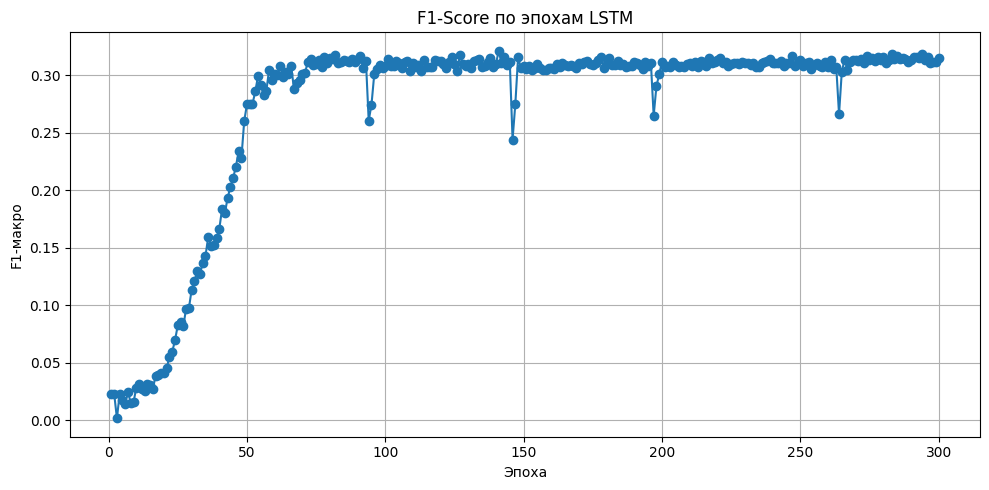

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), f1_historyLSTM, marker='o')
plt.title("F1-Score по эпохам LSTM")
plt.xlabel("Эпоха")
plt.ylabel("F1-макро")
plt.grid(True)
plt.tight_layout()
plt.show()

**ВЫВОДЫ**



1.   RNN - простая структура, быстрое обучение на начальных этапах (за 50 эпох сходится к f1 метрике в 0.33, а LSTM требуется 200 эпох). RNN быстро учит шаблоны, но быстро выходит на плато, из-за относительно простой структуры. RNN имеет ограниченную способность запоминать длинные зависимости из-за проблемы исчезающих градиентов
2.   LSTM - модель сложнее устроена, дольше учится, однако cпособна выявлять сложные долгосрочные зависимости, но медленнее сходится. Это мы видим на обучении (дольше обучается). Обнаружилось еще, что при увеличении HIDDEN_DIM быстрее выходит на порог. К сожалению, LSTM не выходит лучше чем RNN даже спустя 300 эпох, это может быть связанно с тем, что либо последовательности всё равно слишком длинные, либо нужно использовать dropout, batch norm и другие приемы.
3.   Тут очень хорошо идет улучшение архитектуры LSTM - двунаправленность. Она позволяет гораздо точнее уловить зависимости в данных (получается, информация не теряется от эпохи к эпохе, медленнее теряется). Пример ниже:



__Задание 6 (1 балл).__ В этом задании у вас есть две опции на выбор: добавить __двунаправленность__ для LSTM _или_ добавить __многослойность__. Можно сделать и то, и другое, но дополнительных баллов за это мы не дадим, только бесконечный респект. Обе модификации реализуются довольно просто (буквально 4 строчки кода, если вы аккуратно реализовали модель) и дают примерно одинаковый прирост в качестве. Сделайте выводы: стоит ли увеличивать размер модели в несколько раз?

In [ ]:
# Двунаправленность

In [ ]:
# Минимальные изменения
class SimpleDVLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # Добавляем bidirectional=True
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True, bidirectional=True)
        # hidden_dim удваивается из-за двунаправленности - как бы вперед и назад
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

    def forward(self, x):
        mask = (x != 0)
        lengths = mask.sum(1).cpu()
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_out, (hn, cn) = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        last_seq_idxs = lengths - 1
        # Собираем прямое и обратное направление (concat) :)
        forward_out = out[torch.arange(out.size(0)), last_seq_idxs, :self.hidden_dim]
        backward_out = out[:, 0, self.hidden_dim:]  # Обратное направление смотрит с конца
        last_out = torch.cat((forward_out, backward_out), dim=1)

        logits = self.fc(last_out)
        return logits


In [ ]:
# Параметры
VOCAB_SIZE = tokenizer.get_vocab_size() + 1
EMBED_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = y_train.shape[1]
N_LAYERS = 1
EPOCHS = 100
LR = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleDVLSTM(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS)

# Обучение
best_f1, f1_historyLSTM = train_and_evaluate(
    model,
    train_loader,
    test_loader,
    device,
    n_epochs=EPOCHS,
    lr=LR
)


Epoch 1/100: 100%|██████████| 76/76 [00:01<00:00, 59.69it/s, loss=0.1654]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1 | Train Loss: 0.2283 | Test F1: 0.0193


Epoch 2/100: 100%|██████████| 76/76 [00:01<00:00, 64.30it/s, loss=0.1606]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2 | Train Loss: 0.1793 | Test F1: 0.0229


Epoch 3/100: 100%|██████████| 76/76 [00:01<00:00, 65.88it/s, loss=0.1832]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3 | Train Loss: 0.1747 | Test F1: 0.0242


Epoch 4/100: 100%|██████████| 76/76 [00:01<00:00, 65.43it/s, loss=0.1563]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4 | Train Loss: 0.1701 | Test F1: 0.0244


Epoch 5/100: 100%|██████████| 76/76 [00:01<00:00, 65.93it/s, loss=0.1688]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5 | Train Loss: 0.1647 | Test F1: 0.0253


Epoch 6/100: 100%|██████████| 76/76 [00:01<00:00, 65.66it/s, loss=0.1717]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6 | Train Loss: 0.1588 | Test F1: 0.0412


Epoch 7/100: 100%|██████████| 76/76 [00:01<00:00, 57.93it/s, loss=0.1492]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7 | Train Loss: 0.1524 | Test F1: 0.0519


Epoch 8/100: 100%|██████████| 76/76 [00:01<00:00, 50.65it/s, loss=0.1389]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8 | Train Loss: 0.1450 | Test F1: 0.0414


Epoch 9/100: 100%|██████████| 76/76 [00:01<00:00, 64.27it/s, loss=0.1193]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9 | Train Loss: 0.1371 | Test F1: 0.0608


Epoch 10/100: 100%|██████████| 76/76 [00:01<00:00, 63.61it/s, loss=0.1276]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10 | Train Loss: 0.1287 | Test F1: 0.0792


Epoch 11/100: 100%|██████████| 76/76 [00:01<00:00, 42.96it/s, loss=0.1245]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11 | Train Loss: 0.1198 | Test F1: 0.0982


Epoch 12/100: 100%|██████████| 76/76 [00:01<00:00, 41.03it/s, loss=0.1234]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12 | Train Loss: 0.1101 | Test F1: 0.1180


Epoch 13/100: 100%|██████████| 76/76 [00:02<00:00, 36.28it/s, loss=0.1022]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13 | Train Loss: 0.1011 | Test F1: 0.1280


Epoch 14/100: 100%|██████████| 76/76 [00:02<00:00, 35.09it/s, loss=0.0930]


Epoch 14 | Train Loss: 0.0910 | Test F1: 0.1549


Epoch 15/100: 100%|██████████| 76/76 [00:02<00:00, 30.23it/s, loss=0.0778]


Epoch 15 | Train Loss: 0.0813 | Test F1: 0.2014


Epoch 16/100: 100%|██████████| 76/76 [00:01<00:00, 49.04it/s, loss=0.0862]


Epoch 16 | Train Loss: 0.0719 | Test F1: 0.2010


Epoch 17/100: 100%|██████████| 76/76 [00:01<00:00, 65.61it/s, loss=0.0609]


Epoch 17 | Train Loss: 0.0625 | Test F1: 0.2236


Epoch 18/100: 100%|██████████| 76/76 [00:01<00:00, 63.13it/s, loss=0.0610]


Epoch 18 | Train Loss: 0.0536 | Test F1: 0.2736


Epoch 19/100: 100%|██████████| 76/76 [00:01<00:00, 66.27it/s, loss=0.0465]


Epoch 19 | Train Loss: 0.0451 | Test F1: 0.2798


Epoch 20/100: 100%|██████████| 76/76 [00:01<00:00, 64.48it/s, loss=0.0251]


Epoch 20 | Train Loss: 0.0383 | Test F1: 0.3187


Epoch 21/100: 100%|██████████| 76/76 [00:01<00:00, 65.58it/s, loss=0.0281]


Epoch 21 | Train Loss: 0.0318 | Test F1: 0.3316


Epoch 22/100: 100%|██████████| 76/76 [00:01<00:00, 57.65it/s, loss=0.0271]


Epoch 22 | Train Loss: 0.0266 | Test F1: 0.3333


Epoch 23/100: 100%|██████████| 76/76 [00:01<00:00, 51.78it/s, loss=0.0233]


Epoch 23 | Train Loss: 0.0222 | Test F1: 0.3381


Epoch 24/100: 100%|██████████| 76/76 [00:01<00:00, 64.83it/s, loss=0.0179]


Epoch 24 | Train Loss: 0.0188 | Test F1: 0.3507


Epoch 25/100: 100%|██████████| 76/76 [00:01<00:00, 65.47it/s, loss=0.0194]


Epoch 25 | Train Loss: 0.0162 | Test F1: 0.3550


Epoch 26/100: 100%|██████████| 76/76 [00:01<00:00, 65.21it/s, loss=0.0124]


Epoch 26 | Train Loss: 0.0139 | Test F1: 0.3512


Epoch 27/100: 100%|██████████| 76/76 [00:01<00:00, 64.47it/s, loss=0.0101]


Epoch 27 | Train Loss: 0.0119 | Test F1: 0.3535


Epoch 28/100: 100%|██████████| 76/76 [00:01<00:00, 66.54it/s, loss=0.0079]


Epoch 28 | Train Loss: 0.0103 | Test F1: 0.3542


Epoch 29/100: 100%|██████████| 76/76 [00:01<00:00, 65.57it/s, loss=0.0099]


Epoch 29 | Train Loss: 0.0092 | Test F1: 0.3592


Epoch 30/100: 100%|██████████| 76/76 [00:01<00:00, 66.29it/s, loss=0.0159]


Epoch 30 | Train Loss: 0.0085 | Test F1: 0.3559


Epoch 31/100: 100%|██████████| 76/76 [00:01<00:00, 60.59it/s, loss=0.0054]


Epoch 31 | Train Loss: 0.0079 | Test F1: 0.3624


Epoch 32/100: 100%|██████████| 76/76 [00:01<00:00, 52.23it/s, loss=0.0047]


Epoch 32 | Train Loss: 0.0069 | Test F1: 0.3554


Epoch 33/100: 100%|██████████| 76/76 [00:01<00:00, 61.34it/s, loss=0.0113]


Epoch 33 | Train Loss: 0.0064 | Test F1: 0.3614


Epoch 34/100: 100%|██████████| 76/76 [00:01<00:00, 65.00it/s, loss=0.0060]


Epoch 34 | Train Loss: 0.0060 | Test F1: 0.3634


Epoch 35/100: 100%|██████████| 76/76 [00:01<00:00, 66.12it/s, loss=0.0069]


Epoch 35 | Train Loss: 0.0056 | Test F1: 0.3596


Epoch 36/100: 100%|██████████| 76/76 [00:01<00:00, 66.21it/s, loss=0.0058]


Epoch 36 | Train Loss: 0.0056 | Test F1: 0.3579


Epoch 37/100: 100%|██████████| 76/76 [00:01<00:00, 66.51it/s, loss=0.0032]


Epoch 37 | Train Loss: 0.0052 | Test F1: 0.3582


Epoch 38/100: 100%|██████████| 76/76 [00:01<00:00, 65.30it/s, loss=0.0056]


Epoch 38 | Train Loss: 0.0050 | Test F1: 0.3543


Epoch 39/100: 100%|██████████| 76/76 [00:01<00:00, 66.08it/s, loss=0.0082]


Epoch 39 | Train Loss: 0.0050 | Test F1: 0.3519


Epoch 40/100: 100%|██████████| 76/76 [00:01<00:00, 66.12it/s, loss=0.0062]


Epoch 40 | Train Loss: 0.0048 | Test F1: 0.3594


Epoch 41/100: 100%|██████████| 76/76 [00:01<00:00, 53.19it/s, loss=0.0104]


Epoch 41 | Train Loss: 0.0047 | Test F1: 0.3589


Epoch 42/100: 100%|██████████| 76/76 [00:01<00:00, 54.60it/s, loss=0.0041]


Epoch 42 | Train Loss: 0.0046 | Test F1: 0.3535


Epoch 43/100: 100%|██████████| 76/76 [00:01<00:00, 64.65it/s, loss=0.0057]


Epoch 43 | Train Loss: 0.0044 | Test F1: 0.3559


Epoch 44/100: 100%|██████████| 76/76 [00:01<00:00, 64.29it/s, loss=0.0040]


Epoch 44 | Train Loss: 0.0041 | Test F1: 0.3516


Epoch 45/100: 100%|██████████| 76/76 [00:01<00:00, 64.54it/s, loss=0.0014]


Epoch 45 | Train Loss: 0.0041 | Test F1: 0.3574


Epoch 46/100: 100%|██████████| 76/76 [00:01<00:00, 65.60it/s, loss=0.0037]


Epoch 46 | Train Loss: 0.0040 | Test F1: 0.3532


Epoch 47/100: 100%|██████████| 76/76 [00:01<00:00, 66.13it/s, loss=0.0041]


Epoch 47 | Train Loss: 0.0038 | Test F1: 0.3545


Epoch 48/100: 100%|██████████| 76/76 [00:01<00:00, 65.51it/s, loss=0.0104]


Epoch 48 | Train Loss: 0.0038 | Test F1: 0.3593


Epoch 49/100: 100%|██████████| 76/76 [00:01<00:00, 65.90it/s, loss=0.0021]


Epoch 49 | Train Loss: 0.0036 | Test F1: 0.3592


Epoch 50/100: 100%|██████████| 76/76 [00:01<00:00, 56.92it/s, loss=0.0010]


Epoch 50 | Train Loss: 0.0037 | Test F1: 0.3574


Epoch 51/100: 100%|██████████| 76/76 [00:01<00:00, 50.70it/s, loss=0.0076]


Epoch 51 | Train Loss: 0.0036 | Test F1: 0.3613


Epoch 52/100: 100%|██████████| 76/76 [00:01<00:00, 63.85it/s, loss=0.0040]


Epoch 52 | Train Loss: 0.0036 | Test F1: 0.3556


Epoch 53/100: 100%|██████████| 76/76 [00:01<00:00, 64.29it/s, loss=0.0014]


Epoch 53 | Train Loss: 0.0034 | Test F1: 0.3626


Epoch 54/100: 100%|██████████| 76/76 [00:01<00:00, 46.28it/s, loss=0.0009]


Epoch 54 | Train Loss: 0.0034 | Test F1: 0.3564


Epoch 55/100: 100%|██████████| 76/76 [00:01<00:00, 65.77it/s, loss=0.0143]


Epoch 55 | Train Loss: 0.0035 | Test F1: 0.3595


Epoch 56/100: 100%|██████████| 76/76 [00:01<00:00, 64.91it/s, loss=0.0071]


Epoch 56 | Train Loss: 0.0033 | Test F1: 0.3641


Epoch 57/100: 100%|██████████| 76/76 [00:01<00:00, 65.12it/s, loss=0.0055]


Epoch 57 | Train Loss: 0.0033 | Test F1: 0.3544


Epoch 58/100: 100%|██████████| 76/76 [00:01<00:00, 63.92it/s, loss=0.0072]


Epoch 58 | Train Loss: 0.0033 | Test F1: 0.3579


Epoch 59/100: 100%|██████████| 76/76 [00:01<00:00, 54.39it/s, loss=0.0051]


Epoch 59 | Train Loss: 0.0033 | Test F1: 0.3578


Epoch 60/100: 100%|██████████| 76/76 [00:01<00:00, 40.63it/s, loss=0.0097]


Epoch 60 | Train Loss: 0.0034 | Test F1: 0.3572


Epoch 61/100: 100%|██████████| 76/76 [00:01<00:00, 64.27it/s, loss=0.0042]


Epoch 61 | Train Loss: 0.0033 | Test F1: 0.3605


Epoch 62/100: 100%|██████████| 76/76 [00:01<00:00, 64.44it/s, loss=0.0093]


Epoch 62 | Train Loss: 0.0033 | Test F1: 0.3595


Epoch 63/100: 100%|██████████| 76/76 [00:01<00:00, 64.46it/s, loss=0.0006]


Epoch 63 | Train Loss: 0.0032 | Test F1: 0.3578


Epoch 64/100: 100%|██████████| 76/76 [00:01<00:00, 48.05it/s, loss=0.0022]


Epoch 64 | Train Loss: 0.0032 | Test F1: 0.3559


Epoch 65/100: 100%|██████████| 76/76 [00:01<00:00, 38.55it/s, loss=0.0047]


Epoch 65 | Train Loss: 0.0031 | Test F1: 0.3564


Epoch 66/100: 100%|██████████| 76/76 [00:01<00:00, 64.19it/s, loss=0.0006]


Epoch 66 | Train Loss: 0.0031 | Test F1: 0.3542


Epoch 67/100: 100%|██████████| 76/76 [00:01<00:00, 56.40it/s, loss=0.0005]


Epoch 67 | Train Loss: 0.0030 | Test F1: 0.3578


Epoch 68/100: 100%|██████████| 76/76 [00:01<00:00, 51.85it/s, loss=0.0089]


Epoch 68 | Train Loss: 0.0030 | Test F1: 0.3655


Epoch 69/100: 100%|██████████| 76/76 [00:01<00:00, 62.96it/s, loss=0.0019]


Epoch 69 | Train Loss: 0.0029 | Test F1: 0.3577


Epoch 70/100: 100%|██████████| 76/76 [00:01<00:00, 64.61it/s, loss=0.0068]


Epoch 70 | Train Loss: 0.0030 | Test F1: 0.3604


Epoch 71/100: 100%|██████████| 76/76 [00:01<00:00, 63.73it/s, loss=0.0068]


Epoch 71 | Train Loss: 0.0032 | Test F1: 0.3467


Epoch 72/100: 100%|██████████| 76/76 [00:01<00:00, 47.30it/s, loss=0.0119]


Epoch 72 | Train Loss: 0.0037 | Test F1: 0.3528


Epoch 73/100: 100%|██████████| 76/76 [00:01<00:00, 64.13it/s, loss=0.0316]


Epoch 73 | Train Loss: 0.0220 | Test F1: 0.3302


Epoch 74/100: 100%|██████████| 76/76 [00:01<00:00, 64.61it/s, loss=0.0110]


Epoch 74 | Train Loss: 0.0171 | Test F1: 0.3470


Epoch 75/100: 100%|██████████| 76/76 [00:01<00:00, 64.46it/s, loss=0.0024]


Epoch 75 | Train Loss: 0.0074 | Test F1: 0.3584


Epoch 76/100: 100%|██████████| 76/76 [00:01<00:00, 55.75it/s, loss=0.0120]


Epoch 76 | Train Loss: 0.0045 | Test F1: 0.3630


Epoch 77/100: 100%|██████████| 76/76 [00:01<00:00, 50.85it/s, loss=0.0010]


Epoch 77 | Train Loss: 0.0035 | Test F1: 0.3590


Epoch 78/100: 100%|██████████| 76/76 [00:01<00:00, 63.83it/s, loss=0.0035]


Epoch 78 | Train Loss: 0.0032 | Test F1: 0.3592


Epoch 79/100: 100%|██████████| 76/76 [00:01<00:00, 64.52it/s, loss=0.0006]


Epoch 79 | Train Loss: 0.0030 | Test F1: 0.3592


Epoch 80/100: 100%|██████████| 76/76 [00:01<00:00, 64.88it/s, loss=0.0031]


Epoch 80 | Train Loss: 0.0029 | Test F1: 0.3619


Epoch 81/100: 100%|██████████| 76/76 [00:01<00:00, 64.06it/s, loss=0.0052]


Epoch 81 | Train Loss: 0.0028 | Test F1: 0.3614


Epoch 82/100: 100%|██████████| 76/76 [00:01<00:00, 64.74it/s, loss=0.0007]


Epoch 82 | Train Loss: 0.0028 | Test F1: 0.3598


Epoch 83/100: 100%|██████████| 76/76 [00:01<00:00, 65.18it/s, loss=0.0050]


Epoch 83 | Train Loss: 0.0029 | Test F1: 0.3579


Epoch 84/100: 100%|██████████| 76/76 [00:01<00:00, 65.23it/s, loss=0.0004]


Epoch 84 | Train Loss: 0.0028 | Test F1: 0.3610


Epoch 85/100: 100%|██████████| 76/76 [00:01<00:00, 60.63it/s, loss=0.0085]


Epoch 85 | Train Loss: 0.0028 | Test F1: 0.3602


Epoch 86/100: 100%|██████████| 76/76 [00:01<00:00, 51.82it/s, loss=0.0004]


Epoch 86 | Train Loss: 0.0028 | Test F1: 0.3555


Epoch 87/100: 100%|██████████| 76/76 [00:01<00:00, 59.58it/s, loss=0.0035]


Epoch 87 | Train Loss: 0.0027 | Test F1: 0.3575


Epoch 88/100: 100%|██████████| 76/76 [00:01<00:00, 62.75it/s, loss=0.0020]


Epoch 88 | Train Loss: 0.0026 | Test F1: 0.3594


Epoch 89/100: 100%|██████████| 76/76 [00:01<00:00, 64.00it/s, loss=0.0003]


Epoch 89 | Train Loss: 0.0027 | Test F1: 0.3559


Epoch 90/100: 100%|██████████| 76/76 [00:01<00:00, 65.29it/s, loss=0.0034]


Epoch 90 | Train Loss: 0.0026 | Test F1: 0.3563


Epoch 91/100: 100%|██████████| 76/76 [00:01<00:00, 65.31it/s, loss=0.0029]


Epoch 91 | Train Loss: 0.0027 | Test F1: 0.3583


Epoch 92/100: 100%|██████████| 76/76 [00:01<00:00, 65.17it/s, loss=0.0003]


Epoch 92 | Train Loss: 0.0026 | Test F1: 0.3577


Epoch 93/100: 100%|██████████| 76/76 [00:01<00:00, 64.69it/s, loss=0.0032]


Epoch 93 | Train Loss: 0.0025 | Test F1: 0.3613


Epoch 94/100: 100%|██████████| 76/76 [00:01<00:00, 65.23it/s, loss=0.0022]


Epoch 94 | Train Loss: 0.0026 | Test F1: 0.3642


Epoch 95/100: 100%|██████████| 76/76 [00:01<00:00, 52.94it/s, loss=0.0056]


Epoch 95 | Train Loss: 0.0027 | Test F1: 0.3515


Epoch 96/100: 100%|██████████| 76/76 [00:01<00:00, 53.56it/s, loss=0.0050]


Epoch 96 | Train Loss: 0.0026 | Test F1: 0.3619


Epoch 97/100: 100%|██████████| 76/76 [00:01<00:00, 64.27it/s, loss=0.0002]


Epoch 97 | Train Loss: 0.0026 | Test F1: 0.3555


Epoch 98/100: 100%|██████████| 76/76 [00:01<00:00, 65.09it/s, loss=0.0096]


Epoch 98 | Train Loss: 0.0025 | Test F1: 0.3606


Epoch 99/100: 100%|██████████| 76/76 [00:01<00:00, 65.06it/s, loss=0.0055]


Epoch 99 | Train Loss: 0.0027 | Test F1: 0.3579


Epoch 100/100: 100%|██████████| 76/76 [00:01<00:00, 64.56it/s, loss=0.0047]


Epoch 100 | Train Loss: 0.0026 | Test F1: 0.3581
Best F1: 0.3655


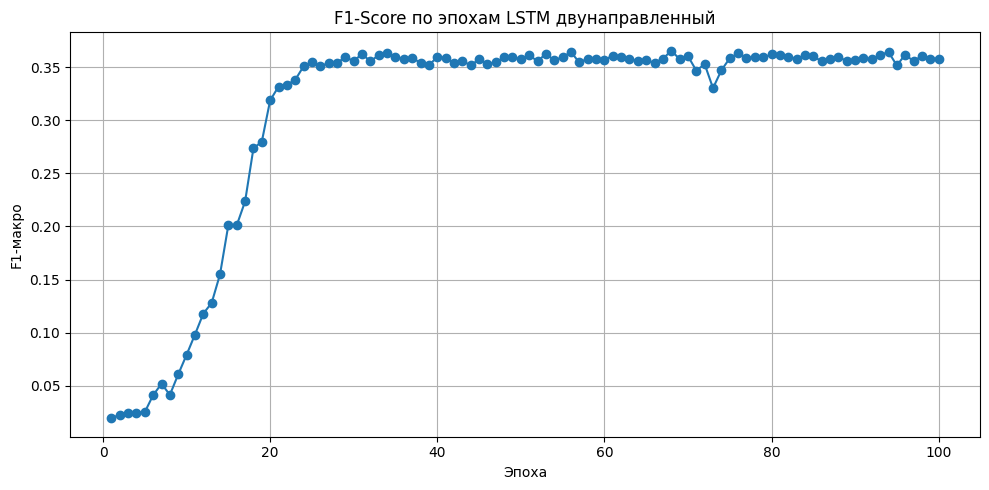

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), f1_historyLSTM, marker='o')
plt.title("F1-Score по эпохам LSTM двунаправленный")
plt.xlabel("Эпоха")
plt.ylabel("F1-макро")
plt.grid(True)
plt.tight_layout()
plt.show()